# Open Food Facts Data Analysis

## Table of Contents

1. [Data Wrangling](#wr) <br>
    2.1 [The Data](#td)<br>
    2.2 [Dealing with NaNs and Duplicates](#dwn) <br>
    2.3 [Data Types](#dt) <br>
    2.4 [Eliminating Outliers](#eo) <br>
    2.5 [Feature Extraction](#fe) <br>
    2.6 [Standardization](#stand) <br>
2. [Exploritory Data Analysis](#eda) <br>
    2.1 [Frequencies](#frq) <br>
    2.1.1 [Distributions](#dist) <br>
    2.1.2 [Variables over Time (Time-Series)](#time) <br>
    2.1.3 [Most common Addatives](#mca)<br>
    2.1.4 [Most common Ingredient](#mci) <br>
    2.2 [Characteristics](#cha) <br>
    2.2.1 [Characteristics of Categories](#coc)<br>
    2.2.2 [Characteristics of Countries](#dbc)<br>
    2.3 [Relationships](#rel) <br>
    2.3.1 [Relationships: nutrition_score_100g](#rns) <br>
    2.3.2 [Relationships: energy_100g](#re) <br>
    2.7 [Correlation](#corr)<br>
    2.5 [Regression](#reg) <br>
    2.6 [Storing the Data](#store)<br>
    2.6.1 [Creating a Database](#cad) <br>
    2.6.1 [Running a Query (Test)](#rq) <br>
    2.6.2 [Adding Data from our Dataframe](#add) <br>
    2.6.3 [Running a Query (Test)](#rq) <br>
3. [Conclusion](#conc) <br>





***

## Data Wrangling
<a id="dw" > 

### The Data
<a id="td" > 

This is a dataset of food products listing the ingredients and nutritional facts of more than 300,000 foods from over 150 countries in the world.
The data is meant to be free to the public to help users decode food labels, and make better food choices in general.
The dataset contains more than 300,000 rows over 163 columns. However, as we will see there are a lot of missing or obviously incorrect values.
- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma-separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutrient (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutrient (in g, or kJ for energy) for 1 serving of the product

- nutrition-score-fr_100g : experimental nutrition score derived from the UK FSA score and adapted for the French market (these fields are of numeric, ranging from -15 to 40. The lower the score, the better)
- nutrition-score-uk_100g : nutrition score defined by the UK Food Standards Administration (these fields are of numeric, ranging from -15 to 40. The lower the score, the better)
- nutrition_grade_fr_100g : Seems to be a simple categorization of the score into A, B, C, D, and E (The UK equivalent contains mostly NaNs)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import re
import sqlite3
from datetime import datetime
from pandas import Series, DataFrame
%matplotlib inline

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

In [3]:
data = pd.read_csv('en.openfoodfacts.org.products.tsv', sep='\t', low_memory=False)

In [4]:
print('There are {:,} rows '.format(data.shape[0]) + 'and {} columns in our data'.format(data.shape[1]))

There are 356,027 rows and 163 columns in our data


In [5]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,...,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,nan,0.001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,14.000,14.000,nan,nan
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071,nan,0.001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000,0.000,nan,nan
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.143,nan,0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12.000,12.000,nan,nan
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,NaN,NaN,Bob's Red Mill,bob-s-red-mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [6]:
data.set_index('code', inplace=True)

In [7]:
print("This data is really messy! \nthe 'countries_en' column contians {} \"unique\" countries ".format(data['countries_en'].dropna().unique().shape[0]))

This data is really messy! 
the 'countries_en' column contians 779 "unique" countries 


In [8]:
# We drop all columns that we deem not interesting and we don't intend to use for our investigation.
data = data.drop(columns=['creator',
                          'brands',
                          'brands_tags',
                          'categories',
                          'main_category',
                          'countries',
                          'countries_tags',
                          'additives',
                          'additives_tags',
                          'categories_tags',
                          'states',
                          'states_en',
                          'states_tags',
                          'url',
                          'quantity',
                          'packaging_tags',
                          'packaging',
                          'created_t',
                          'last_modified_t',
                          'ingredients_from_palm_oil_n', 
                          'ingredients_that_may_be_from_palm_oil_n',
                          'pnns_groups_1',
                          'pnns_groups_2',
                          'image_url',
                          'image_small_url',
                         ])

In [9]:
print('There are {:,} rows '.format(data.shape[0]) + 'and {} columns left in our data'.format(data.shape[1]))

There are 356,027 rows and 137 columns left in our data


### Dealing with NaNs and Duplicates
<a id="dwn" > 

In [10]:
data.isnull().sum().sort_values()

last_modified_datetime                        0
created_datetime                             10
countries_en                                275
product_name                              17512
energy_100g                               60660
proteins_100g                             61866
salt_100g                                 66288
sodium_100g                               66333
ingredients_text                          72134
additives_n                               72160
fat_100g                                  76530
carbohydrates_100g                        76807
sugars_100g                               76841
saturated-fat_100g                        92204
nutrition-score-fr_100g                  101171
nutrition-score-uk_100g                  101171
nutrition_grade_fr                       101171
fiber_100g                               135344
serving_size                             139406
additives_en                             185838
cholesterol_100g                        

In [11]:
# We rename all columns that contain a "-" since in some scenarios this can cause problems with python 3
data = data.rename(columns={'nutrition-score-fr_100g': 'nutrition_score_fr_100g',
                            'nutrition-score-uk_100g': 'nutrition_score_uk_100g',
                            'vitamin-c_100g': 'vitamin_c_100g',
                            'vitamin-a_100g': 'vitamin_a_100g',
                            'saturated-fat_100g': 'saturated_fat_100g',
                            'trans-fat_100g': 'trans_fat_100g'})

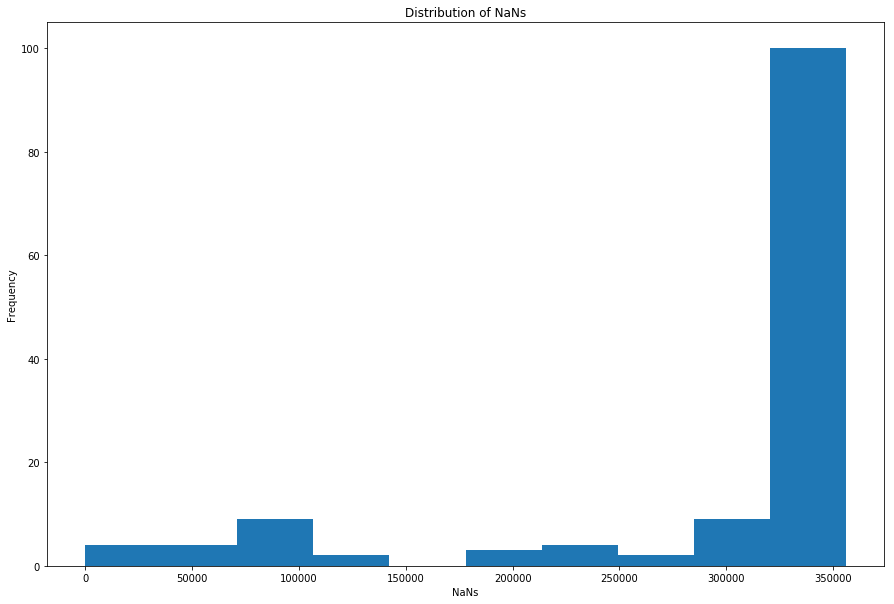

In [12]:
data.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

In [13]:
# We drop all columns that contain less than 20% usable data
data = data.dropna(axis=1, thresh= len(data)*0.2, how='all') 

In [14]:
# drop all rows that (after dropping some columns) only contain NaNs
data = data.dropna(axis=0, how='all') 

In [15]:
print('There are now {:,} rows '.format(data.shape[0]) + 'and {} columns left in our data'.format(data.shape[1]))

There are now 356,027 rows and 28 columns left in our data


In [16]:
data.isnull().sum().sort_values()

last_modified_datetime          0
created_datetime               10
countries_en                  275
product_name                17512
energy_100g                 60660
proteins_100g               61866
salt_100g                   66288
sodium_100g                 66333
ingredients_text            72134
additives_n                 72160
fat_100g                    76530
carbohydrates_100g          76807
sugars_100g                 76841
saturated_fat_100g          92204
nutrition_grade_fr         101171
nutrition_score_fr_100g    101171
nutrition_score_uk_100g    101171
fiber_100g                 135344
serving_size               139406
additives_en               185838
cholesterol_100g           211857
trans_fat_100g             212584
calcium_100g               214510
vitamin_c_100g             214967
iron_100g                  215367
vitamin_a_100g             218321
categories_en              252726
main_category_en           252778
dtype: int64

In [17]:
data['product_name'].fillna(value='Product name unavailable', inplace=True)

In [18]:
data.head()

,created_datetime,last_modified_datetime,product_name,categories_en,countries_en,ingredients_text,serving_size,additives_n,additives_en,nutrition_grade_fr,main_category_en,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000000003087,2016-09-17T09:17:46Z,2016-09-17T09:18:13Z,Farine de blé noir,NaN,France,NaN,NaN,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0000000004530,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0.000,NaN,d,NaN,2243.000,28.570,28.570,0.000,0.018,64.290,14.290,3.600,3.570,0.000,0.000,0.000,0.021,0.000,0.001,14.000,14.000
0000000004559,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Peanuts,NaN,United States,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.000,NaN,b,NaN,1941.000,17.860,0.000,0.000,0.000,60.710,17.860,7.100,17.860,0.635,0.250,0.000,0.000,0.071,0.001,0.000,0.000
0000000016087,2017-03-09T10:35:31Z,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,United States,"Organic hazelnuts, organic cashews, organic wa...",28 g (0.25 cup),0.000,NaN,d,NaN,2540.000,57.140,5.360,nan,nan,17.860,3.570,7.100,17.860,1.224,0.482,nan,nan,0.143,0.005,12.000,12.000
0000000016094,2017-03-09T10:34:13Z,2017-03-09T10:34:13Z,Organic Polenta,NaN,United States,Organic polenta,35 g (0.25 cup),0.000,NaN,NaN,NaN,1552.000,1.430,nan,nan,nan,77.140,nan,5.700,8.570,nan,nan,nan,nan,nan,nan,nan,nan


In [19]:
# We check whether there are any duplicates in our data (this excludes out index-column)
data.duplicated().sum()

685

In [20]:
data[data.duplicated(keep=False)].head(20)

,created_datetime,last_modified_datetime,product_name,categories_en,countries_en,ingredients_text,serving_size,additives_n,additives_en,nutrition_grade_fr,main_category_en,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0010300148647,2017-03-09T13:04:20Z,2017-03-09T13:04:20Z,Chopped Pecans,NaN,United States,Pecans,30 g (0.25 cup),0.000,NaN,c,NaN,2929.000,73.330,6.670,0.000,0.000,13.330,3.330,10.000,10.000,0.000,0.000,0.000,0.000,0.067,0.002,9.000,9.000
0011110196125,2017-03-09T16:43:52Z,2017-03-09T16:43:52Z,Christmas Cupcakes,NaN,United States,"Cake: sugar, bleached enriched flour (bleached...",57 g (1 CUPCAKE),2.000,"E101 - Riboflavin,E101i - Riboflavin,E375 - Ni...",e,NaN,1908.000,19.300,5.260,0.000,0.035,70.180,52.630,1.800,3.510,1.115,0.439,0.000,0.000,0.035,0.002,22.000,22.000
0011110196132,2017-03-09T16:43:52Z,2017-03-09T16:43:52Z,Christmas Cupcakes,NaN,United States,"Cake: sugar, bleached enriched flour (bleached...",57 g (1 CUPCAKE),2.000,"E101 - Riboflavin,E101i - Riboflavin,E375 - Ni...",e,NaN,1908.000,19.300,5.260,0.000,0.035,70.180,52.630,1.800,3.510,1.115,0.439,0.000,0.000,0.035,0.002,22.000,22.000
0011110502865,2017-03-09T20:51:12Z,2017-03-09T20:51:12Z,2% Reduced Fat Milk,NaN,United States,"Milk, skim milk, vitamin a palmitate, vitamin d3.",240 ml (8 fl oz),0.000,NaN,b,NaN,209.000,2.080,1.250,0.000,0.008,5.000,4.580,0.000,3.330,0.127,0.050,0.000,0.001,0.125,0.000,0.000,0.000
0011110502971,2017-03-09T20:51:12Z,2017-03-09T20:51:12Z,2% Reduced Fat Milk,NaN,United States,"Milk, skim milk, vitamin a palmitate, vitamin d3.",240 ml (8 fl oz),0.000,NaN,b,NaN,209.000,2.080,1.250,0.000,0.008,5.000,4.580,0.000,3.330,0.127,0.050,0.000,0.001,0.125,0.000,0.000,0.000
0011110669551,2017-03-10T10:52:52Z,2017-03-10T10:52:52Z,Soy Sauce,NaN,United States,"Water, hydrolyzed soy protein, salt, dextrose,...",15 ml (1 Tbsp),1.000,E150a - Plain caramel,NaN,NaN,418.000,0.000,nan,nan,nan,13.330,6.670,nan,6.670,22.352,8.800,nan,nan,nan,nan,nan,nan
0011110702098,2017-03-10T10:52:52Z,2017-03-10T10:52:52Z,Soy Sauce,NaN,United States,"Water, hydrolyzed soy protein, salt, dextrose,...",15 ml (1 Tbsp),1.000,E150a - Plain caramel,NaN,NaN,418.000,0.000,nan,nan,nan,13.330,6.670,nan,6.670,22.352,8.800,nan,nan,nan,nan,nan,nan
0011110847539,2017-03-09T12:34:28Z,2017-03-09T12:34:28Z,Pinto Beans,NaN,United States,Pinto beans.,35 g (0.25 cup),0.000,NaN,a,NaN,1075.000,0.000,0.000,0.000,0.000,57.140,2.860,14.300,20.000,0.036,0.014,0.000,0.007,0.114,0.005,-7.000,-7.000
0011110859617,2017-03-09T12:34:28Z,2017-03-09T12:34:28Z,Pinto Beans,NaN,United States,Pinto beans.,35 g (0.25 cup),0.000,NaN,a,NaN,1075.000,0.000,0.000,0.000,0.000,57.140,2.860,14.300,20.000,0.036,0.014,0.000,0.007,0.114,0.005,-7.000,-7.000


In [21]:
# We drop all duplicates from our data
data.drop_duplicates(inplace=True)

### Data Types
<a id="dt" > 

In [22]:
data.dtypes

created_datetime            object
last_modified_datetime      object
product_name                object
categories_en               object
countries_en                object
ingredients_text            object
serving_size                object
additives_n                float64
additives_en                object
nutrition_grade_fr          object
main_category_en            object
energy_100g                float64
fat_100g                   float64
saturated_fat_100g         float64
trans_fat_100g             float64
cholesterol_100g           float64
carbohydrates_100g         float64
sugars_100g                float64
fiber_100g                 float64
proteins_100g              float64
salt_100g                  float64
sodium_100g                float64
vitamin_a_100g             float64
vitamin_c_100g             float64
calcium_100g               float64
iron_100g                  float64
nutrition_score_fr_100g    float64
nutrition_score_uk_100g    float64
dtype: object

In [23]:
data['created_datetime'] = pd.to_datetime(data['created_datetime'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

In [24]:
data['last_modified_datetime'] = pd.to_datetime(data['last_modified_datetime'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

In [25]:
data[['created_datetime', 'last_modified_datetime']].isnull().sum()

created_datetime          27
last_modified_datetime    26
dtype: int64

In [26]:
# We fills the nulls
data['created_datetime'].fillna(method='ffill', inplace=True)
data['last_modified_datetime'].fillna(method='ffill', inplace=True)

### Eliminating Outliers
<a id="eo" > 

In [27]:
data.describe()

,additives_n,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
count,283209.000,294709.000,278839.000,263299.000,142935.000,143672.000,278563.000,278650.000,220253.000,293505.000,289083.000,289038.000,137279.000,140635.000,141092.000,140229.000,254419.000,254419.000
mean,1.879,1125.455,56198.136,5.094,0.074,0.020,56272.547,15.669,385097.088,53385.020,1.943,0.765,0.000,0.023,0.127,0.004,9.172,8.986
std,2.502,936.518,29668789.420,7.966,1.542,0.359,29683483.653,21.973,180729014.070,28918038.561,120.682,47.516,0.073,2.238,3.354,0.217,8.999,9.151
min,0.000,0.000,0.000,0.000,-3.570,0.000,0.000,-17.860,-6.700,-800.000,0.000,0.000,-0.000,-0.002,0.000,-0.000,-15.000,-15.000
25%,0.000,384.000,0.100,0.000,0.000,0.000,5.600,1.200,0.000,0.770,0.060,0.024,0.000,0.000,0.000,0.000,1.000,1.000
50%,1.000,1092.000,5.300,1.790,0.000,0.000,20.000,5.400,1.500,4.900,0.560,0.220,0.000,0.000,0.036,0.001,10.000,9.000
75%,3.000,1674.000,20.000,7.140,0.000,0.020,57.580,23.330,3.600,10.000,1.359,0.535,0.000,0.004,0.107,0.002,16.000,16.000
max,30.000,231199.000,15666666000.000,550.000,369.000,95.238,15666666000.000,3520.000,84818150000.000,15666666000.000,64312.800,25320.000,26.700,716.981,694.737,50.000,40.000,40.000


Closer inspection of the min and max values reveals that there are obvious errors in our data.

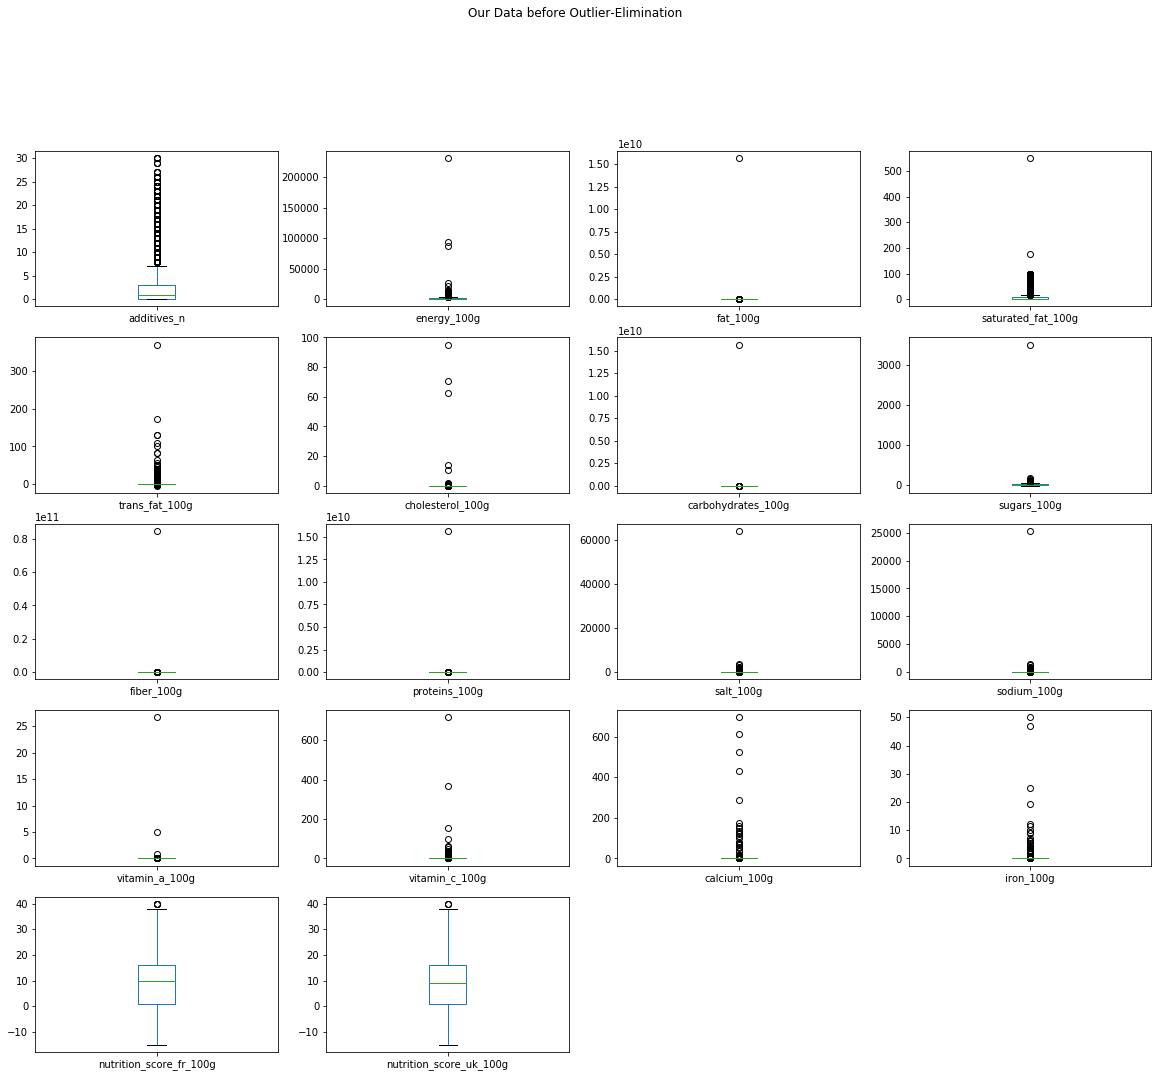

In [28]:
data.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data before Outlier-Elimination', figsize=(20,20), layout=(6,4))

plt.show()

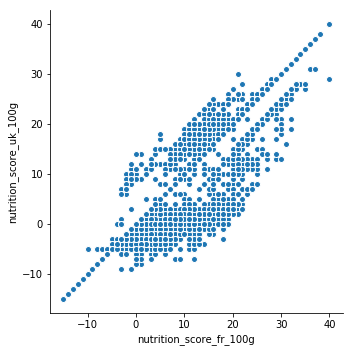

In [29]:
sns.pairplot(data, x_vars=['nutrition_score_fr_100g'], y_vars=['nutrition_score_uk_100g'], size=5)

plt.show()

We will now eliminate all rows, which contain values that are impossible by definition.

In [30]:
data = data[(data[data.columns.difference(['energy_100g'])] <= 100).all(1)]

In [31]:
data = data[(data[data.columns.difference(['nutrition_score_fr_100g', 'nutrition_score_uk_100g'])] >= 0).all(1)]

In [32]:
data = data[(data['fat_100g'] + data['carbohydrates_100g'] + data['proteins_100g'])<=100]

In [33]:
data[data['nutrition_score_uk_100g'] != data['nutrition_score_fr_100g']].shape

(175, 28)

In [34]:
data[data['nutrition_score_uk_100g'] == data['nutrition_score_fr_100g']].shape

(124054, 28)

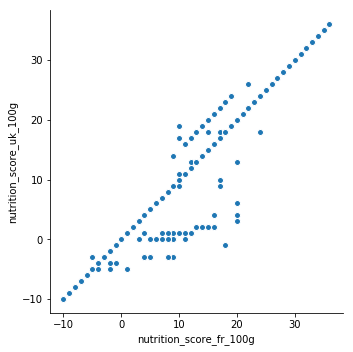

In [35]:
sns.pairplot(data, x_vars=['nutrition_score_fr_100g'], y_vars=['nutrition_score_uk_100g'], size=5)

plt.show()

After Eliminating all obviously flawed values and looking at both of our scores, we have to conclude that they are probably (supposed to be) equal. We therefore create a new column nutrition_score_100g' and delete the old ones.

In [36]:
data['nutrition_score_100g'] = data['nutrition_score_uk_100g'][data['nutrition_score_uk_100g'] == data['nutrition_score_fr_100g']]

In [37]:
data = data.drop(columns=['nutrition_score_uk_100g', 'nutrition_score_fr_100g'])

In [38]:
data.describe()

,additives_n,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_100g
count,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124229.000,124054.000
mean,2.054,1202.244,13.205,4.648,0.061,0.018,35.217,15.244,2.824,7.914,1.276,0.502,0.000,0.006,0.092,0.002,9.326
std,2.612,740.065,15.344,6.758,0.922,0.272,28.075,19.398,4.355,8.134,3.625,1.427,0.001,0.107,0.234,0.151,9.015
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-10.000
25%,0.000,490.000,0.800,0.000,0.000,0.000,8.930,1.670,0.000,2.350,0.145,0.057,0.000,0.000,0.000,0.000,1.000
50%,1.000,1255.000,7.500,1.760,0.000,0.000,28.120,5.730,1.500,5.560,0.747,0.294,0.000,0.000,0.035,0.001,10.000
75%,3.000,1745.000,21.430,7.060,0.000,0.019,60.610,23.880,3.600,10.710,1.450,0.571,0.000,0.002,0.100,0.002,16.000
max,30.000,14644.000,100.000,100.000,100.000,95.238,100.000,100.000,100.000,100.000,99.906,39.333,0.052,35.714,50.000,50.000,36.000


In [39]:
# We eliminate all values (outliers) that are more than 3 std's from the mean
data = data[np.abs(data['additives_n']-data['additives_n'].mean())<=(3*data['additives_n'].std())]
data = data[np.abs(data['energy_100g']-data['energy_100g'].mean())<=(3*data['energy_100g'].std())]
data = data[np.abs(data['fat_100g']-data['fat_100g'].mean())<=(3*data['fat_100g'].std())]
data = data[np.abs(data['saturated_fat_100g']-data['saturated_fat_100g'].mean())<=(3*data['saturated_fat_100g'].std())]
data = data[np.abs(data['trans_fat_100g']-data['trans_fat_100g'].mean())<=(3*data['trans_fat_100g'].std())]
data = data[np.abs(data['cholesterol_100g']-data['cholesterol_100g'].mean())<=(3*data['cholesterol_100g'].std())]
data = data[np.abs(data['carbohydrates_100g']-data['carbohydrates_100g'].mean())<=(3*data['carbohydrates_100g'].std())]
data = data[np.abs(data['sugars_100g']-data['sugars_100g'].mean())<=(3*data['sugars_100g'].std())]
data = data[np.abs(data['fiber_100g']-data['fiber_100g'].mean())<=(3*data['fiber_100g'].std())]
data = data[np.abs(data['proteins_100g']-data['proteins_100g'].mean())<=(3*data['proteins_100g'].std())]
data = data[np.abs(data['salt_100g']-data['salt_100g'].mean())<=(3*data['salt_100g'].std())]
data = data[np.abs(data['sodium_100g']-data['sodium_100g'].mean())<=(3*data['sodium_100g'].std())]
data = data[np.abs(data['vitamin_a_100g']-data['vitamin_a_100g'].mean())<=(3*data['vitamin_a_100g'].std())]
data = data[np.abs(data['vitamin_c_100g']-data['vitamin_c_100g'].mean())<=(3*data['vitamin_c_100g'].std())]
data = data[np.abs(data['calcium_100g']-data['calcium_100g'].mean())<=(3*data['calcium_100g'].std())]
data = data[np.abs(data['iron_100g']-data['iron_100g'].mean())<=(3*data['iron_100g'].std())]
data = data[np.abs(data['nutrition_score_100g']-data['nutrition_score_100g'].mean())<=(3*data['nutrition_score_100g'].std())]

In [40]:
print("There are {:,} rows left in our data ".format(data.shape[0]))

There are 102,882 rows left in our data 


In [41]:
data.describe()

,additives_n,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_100g
count,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000,102882.000
mean,1.889,1140.158,11.842,3.818,0.013,0.013,35.548,14.957,2.572,6.839,0.876,0.345,0.000,0.005,0.061,0.002,8.401
std,2.053,728.153,13.468,5.154,0.139,0.024,27.416,17.861,3.092,6.287,0.877,0.345,0.000,0.017,0.088,0.003,8.835
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-10.000
25%,0.000,418.000,0.780,0.000,0.000,0.000,10.000,2.040,0.000,2.330,0.137,0.054,0.000,0.000,0.000,0.000,1.000
50%,1.000,1134.000,6.670,1.500,0.000,0.000,28.295,6.430,1.600,5.130,0.693,0.273,0.000,0.000,0.031,0.001,8.000
75%,3.000,1724.000,20.000,6.250,0.000,0.016,60.710,23.810,3.600,10.000,1.270,0.500,0.000,0.003,0.090,0.002,15.000
max,9.000,3435.000,58.060,23.330,2.780,0.119,100.000,73.330,16.000,31.580,4.582,1.804,0.001,0.341,0.595,0.120,34.000


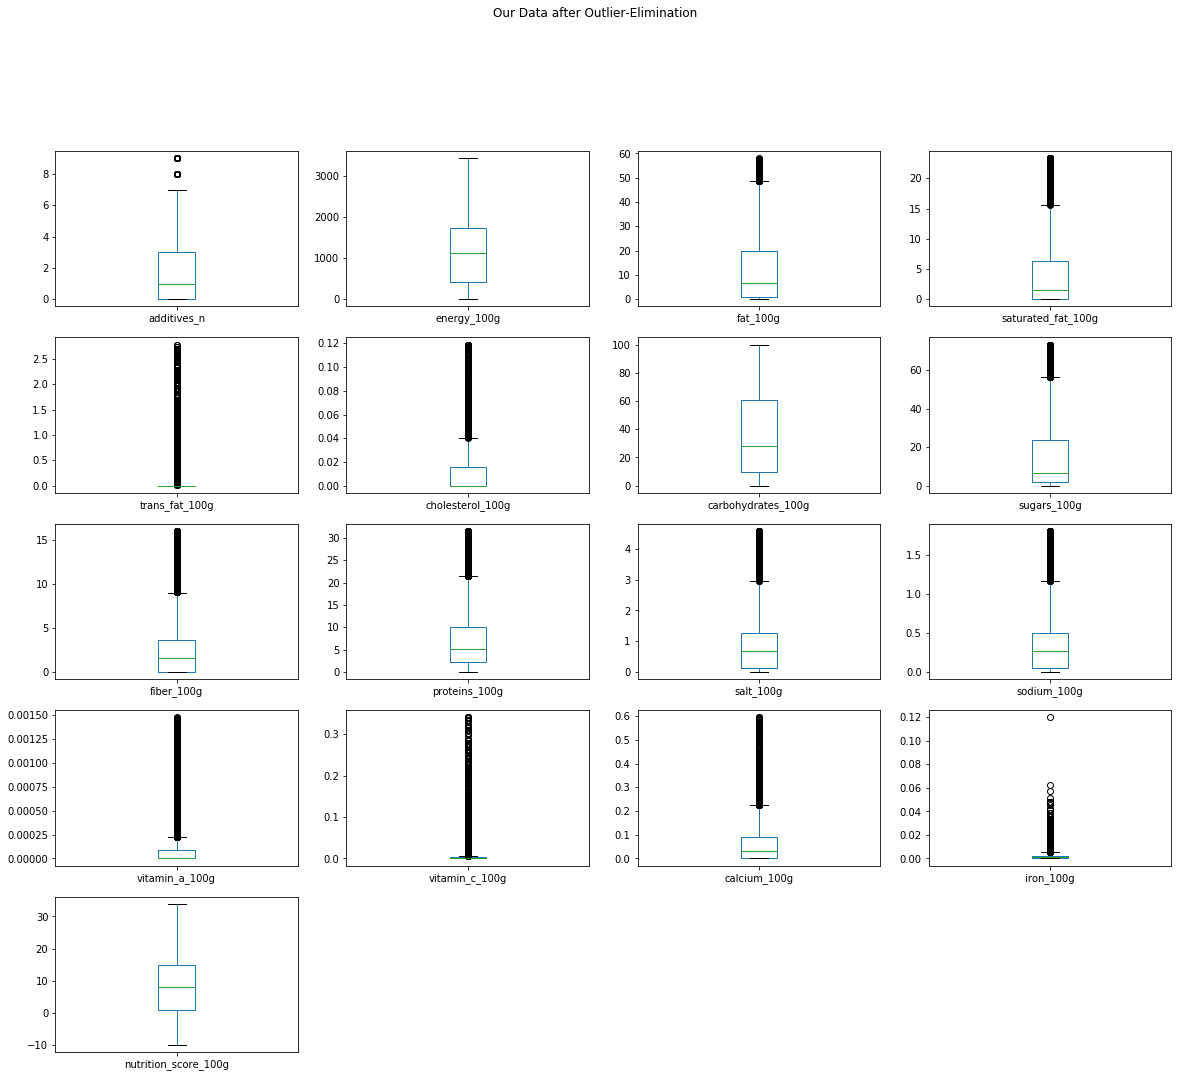

In [42]:
data.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data after Outlier-Elimination', figsize=(20,20), layout=(6,4))

plt.show()

### Feature Extraction
<a id="fe" > 

In [43]:
# We create a new column 'time_delta' that represents the difference in time between creation and modification
data['time_delta'] = (data['created_datetime'] - data['last_modified_datetime'])

In [44]:
# We use the column 'serving_size' to indicate whether the product is liquid or solid (1/0)
data['is_liquid_binary'] = data['serving_size'].str.contains('l|oz', case=False).dropna().astype(int)
data['liquid/solid'] = data['is_liquid_binary'].map({1:'liquid',0:'solid'})

In [45]:
# We use a regular expression to extract the numeric amount of grams from the 'serving_size' column
data['serving_size_in_g'] = data['serving_size'].str.extract('(\d?\d?\d)', expand=True ).dropna().astype(int)

In [46]:
data.isnull().sum()

created_datetime               0
last_modified_datetime         0
product_name                   0
categories_en             101725
countries_en                   0
ingredients_text               0
serving_size                   3
additives_n                    0
additives_en               33923
nutrition_grade_fr             0
main_category_en          101725
energy_100g                    0
fat_100g                       0
saturated_fat_100g             0
trans_fat_100g                 0
cholesterol_100g               0
carbohydrates_100g             0
sugars_100g                    0
fiber_100g                     0
proteins_100g                  0
salt_100g                      0
sodium_100g                    0
vitamin_a_100g                 0
vitamin_c_100g                 0
calcium_100g                   0
iron_100g                      0
nutrition_score_100g           0
time_delta                     0
is_liquid_binary               3
liquid/solid                   3
serving_si

In [47]:
data.dropna(subset=['is_liquid_binary', 'liquid/solid', 'serving_size_in_g'], inplace=True)

In [48]:
data.head()

,created_datetime,last_modified_datetime,product_name,categories_en,countries_en,ingredients_text,serving_size,additives_n,additives_en,nutrition_grade_fr,main_category_en,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_100g,time_delta,is_liquid_binary,liquid/solid,serving_size_in_g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000000004559,2017-03-09 14:32:37,2017-03-09 14:32:37,Peanuts,NaN,United States,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.000,NaN,b,NaN,1941.000,17.860,0.000,0.000,0.000,60.710,17.860,7.100,17.860,0.635,0.250,0.000,0.000,0.071,0.001,0.000,00:00:00,0.000,solid,28.000
0000000033640,2017-03-09 09:07:04,2017-03-09 09:07:05,Granola Cranberry And Acai,NaN,United States,"Whole rolled oats, milled cane sugar, vegetabl...",55 g (0.5 cup),0.000,NaN,c,NaN,1824.000,10.910,0.910,0.000,0.000,74.550,25.450,5.500,9.090,0.254,0.100,0.000,0.000,0.036,0.003,6.000,-1 days +23:59:59,0.000,solid,55.000
0000000033688,2017-03-09 09:07:04,2017-03-09 09:07:04,"Peanuts, Mixed Nuts",NaN,United States,"Peanuts, honey, coating (sucrose, wheat starch...",28 g (0.25 cup),1.000,E415 - Xanthan gum,d,NaN,2389.000,42.860,7.140,0.000,0.000,25.000,14.290,7.100,25.000,0.544,0.214,0.000,0.000,0.071,0.005,14.000,00:00:00,0.000,solid,28.000
0000000043595,2017-03-09 09:07:04,2017-03-09 09:07:04,Cranberries,NaN,United States,"Cranberries, sugar, sunflower oil.",30 g (0.25 cup),0.000,NaN,c,NaN,1255.000,0.000,0.000,0.000,0.000,83.330,66.670,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.000,00:00:00,0.000,solid,30.000
0000000045292,2017-03-09 14:32:38,2017-03-09 14:32:38,Turkish Apricots,NaN,United States,"Apricots, sulfur dioxide.",40 g (7 PIECES),1.000,E220 - Sulphur dioxide,c,NaN,1046.000,0.000,0.000,0.000,0.000,62.500,52.500,7.500,2.500,0.000,0.000,0.001,0.000,0.050,0.004,8.000,00:00:00,0.000,solid,40.000


In [49]:
# We split all entries in the 'additives_en' column and create a new row for each in one new dataframe
exp_additives = data['additives_en'].str.split(',').apply(Series, 1).stack()
exp_additives.index = exp_additives.index.droplevel(-1)
exp_additives.name = 'additives_exp'
data_exp_additives = data.join(exp_additives)

In [50]:
# We split all entries in the 'ingredients_text' column and create a new row for each in one new dataframe
exp_ingredients = data['ingredients_text'].str.split(',').apply(Series, 1).stack()
exp_ingredients.index = exp_ingredients.index.droplevel(-1)
exp_ingredients.name = 'ingredients_exp'
data_exp_ingredients = data.join(exp_ingredients)

In [51]:
# We split all entries in the 'categories_en' column and create a new row for each in one new dataframe
# We use the 'categories_en' column rather than th 'main_column' because there are many NaNs and this way we get more data
exp_categories = data['categories_en'].str.split(',').apply(Series, 1).stack()
exp_categories.index = exp_categories.index.droplevel(-1)
exp_categories.name = 'categories_exp'
data_exp_categories = data.join(exp_categories)

In [52]:
# We split all entries in the 'countries_en' column and create a new row for each in one new dataframe
exp_countries = data['countries_en'].str.split(',').apply(Series, 1).stack()
exp_countries.index = exp_countries.index.droplevel(-1)
exp_countries.name = 'countries_exp'
data_exp_countries = data.join(exp_countries)

### Standardization
<a id="stand" > 

We also create a standardized version of our data for investigation with different statistical methods like regression analysis.

In [53]:
stand_data = data.select_dtypes(include=float).transform(lambda x: (x - x.mean()) / x.std())

In [54]:
stand_data.describe()

,additives_n,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_100g,is_liquid_binary,serving_size_in_g
count,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000
mean,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.920,-1.566,-0.879,-0.741,-0.094,-0.548,-1.297,-0.837,-0.832,-1.088,-0.999,-0.999,-0.445,-0.286,-0.699,-0.544,-2.083,-0.514,-1.116
25%,-0.920,-0.992,-0.821,-0.741,-0.094,-0.548,-0.932,-0.723,-0.832,-0.717,-0.842,-0.842,-0.445,-0.286,-0.699,-0.544,-0.838,-0.514,-0.682
50%,-0.433,-0.008,-0.384,-0.450,-0.094,-0.548,-0.265,-0.477,-0.314,-0.272,-0.208,-0.208,-0.445,-0.286,-0.346,-0.221,-0.045,-0.514,-0.394
75%,0.541,0.802,0.606,0.472,-0.094,0.131,0.918,0.496,0.332,0.503,0.450,0.450,0.066,-0.128,0.326,0.205,0.747,-0.514,0.502
max,3.463,3.152,3.432,3.786,19.858,4.507,2.351,3.268,4.343,3.935,4.228,4.228,7.850,19.700,6.080,38.175,2.898,1.944,12.543


In [55]:
stand_data.dropna(inplace=True)

In [56]:
print('There are {:,} rows '.format(stand_data.shape[0]) + 'and {} columns in our standardized data'.format(stand_data.shape[1]))

There are 102,879 rows and 19 columns in our standardized data


***

## Exploratory Data Analysis
<a id="eda" > 

In the first half of our investigation we will primarily focus and on the following three areas:
1. Frequencies (how are our variables distributed and what are the most common additives and ingredients?)
2. Characteristics (what are the characteristics of the different categories and countries?)
3. Relationships (how are the variables related to each other)

We will subsequently investigate our data with correlations and regression analysis.

### Frequencies
<a id="frq" >

#### Distributions
<a id="dist" >

In [57]:
data.describe()

,additives_n,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_100g,time_delta,is_liquid_binary,serving_size_in_g
count,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879.000,102879,102879.000,102879.000
mean,1.890,1140.129,11.841,3.818,0.013,0.013,35.548,14.957,2.572,6.838,0.876,0.345,0.000,0.005,0.061,0.002,8.401,-5 days +19:50:32.265204,0.209,77.267
std,2.053,728.142,13.468,5.154,0.139,0.024,27.416,17.861,3.092,6.287,0.877,0.345,0.000,0.017,0.088,0.003,8.835,51 days 05:51:08.754004,0.407,69.258
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-10.000,-1670 days +03:00:25,0.000,0.000
25%,0.000,418.000,0.780,0.000,0.000,0.000,10.000,2.040,0.000,2.330,0.137,0.054,0.000,0.000,0.000,0.000,1.000,0 days 00:00:00,0.000,30.000
50%,1.000,1134.000,6.670,1.500,0.000,0.000,28.290,6.430,1.600,5.130,0.693,0.273,0.000,0.000,0.031,0.001,8.000,0 days 00:00:00,0.000,50.000
75%,3.000,1724.000,20.000,6.250,0.000,0.016,60.710,23.810,3.600,10.000,1.270,0.500,0.000,0.003,0.090,0.002,15.000,0 days 00:00:00,0.000,112.000
max,9.000,3435.000,58.060,23.330,2.780,0.119,100.000,73.330,16.000,31.580,4.582,1.804,0.001,0.341,0.595,0.120,34.000,0 days 00:00:00,1.000,946.000


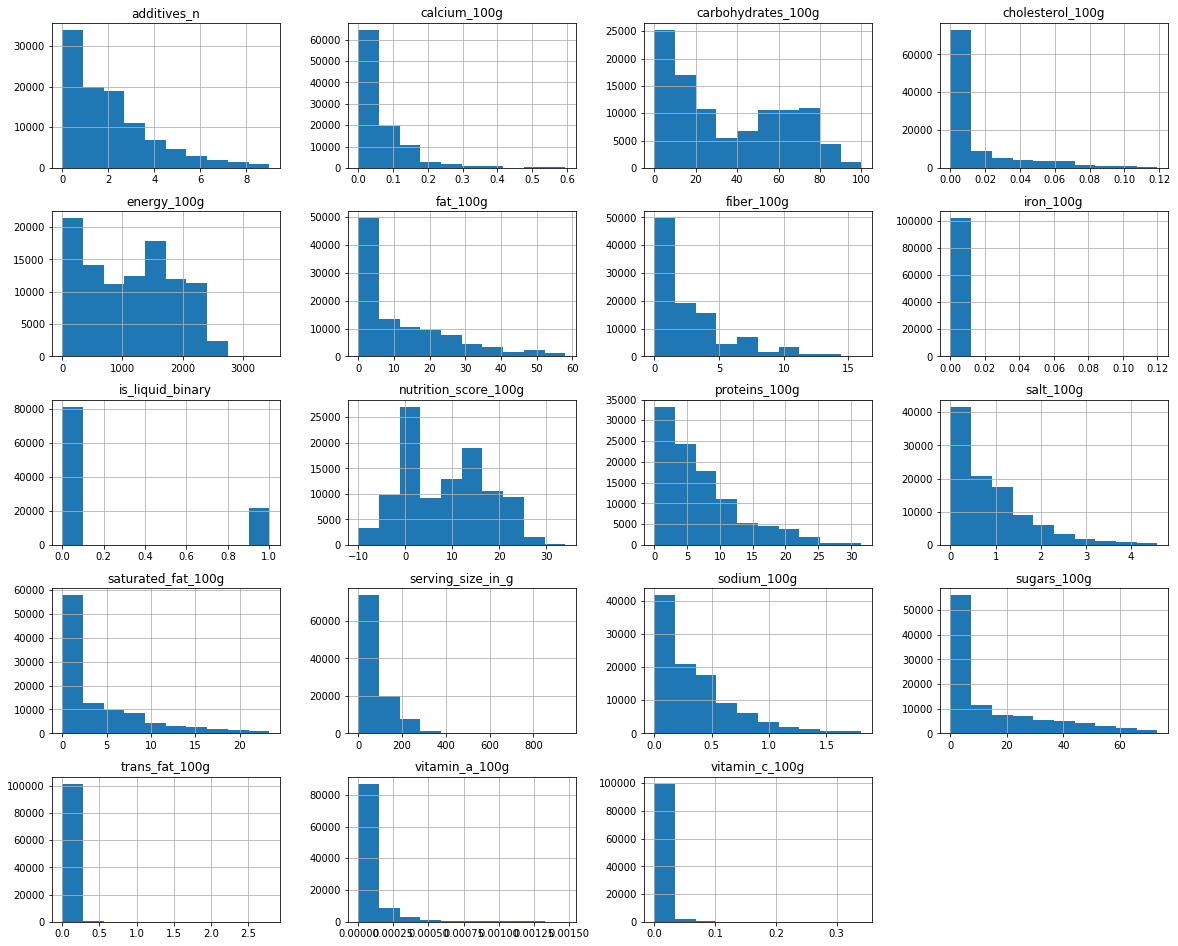

In [58]:
data.hist(figsize=(20,20), layout=(6,4))

plt.show()

-  Hardly any normal distributions with the exeption of the nutrition score.

#### Variables over Time (Time-Series)
<a id="time" > 

In [59]:
data.reset_index(inplace=True)

In [60]:
data.set_index('created_datetime', inplace=True)

In [61]:
data['time_delta'].describe()

count                      102879
mean     -5 days +19:50:32.265204
std       51 days 05:51:08.754004
min          -1670 days +03:00:25
25%               0 days 00:00:00
50%               0 days 00:00:00
75%               0 days 00:00:00
max               0 days 00:00:00
Name: time_delta, dtype: object

In [62]:
print('The mean difference between the time an entry was createted and modified is {} days'.format(data['time_delta'].mean().days))

The mean difference between the time an entry was createted and modified is -5 days


In [63]:
products_per_months = data['product_name'].groupby(data.index.month)

In [64]:
products_per_months.describe()

,count,unique,top,freq
created_datetime,,,,
1,165,163,Tomato Ketchup,2
2,112,110,Oreo,2
3,101991,69687,Ice Cream,393
4,61,61,Tabouleh Wheat Salad Mix,1
5,28,28,Peeled Snacks Much-Ado-About-Mango,1
6,34,34,Sea salt garden veggie sticks,1
7,169,166,Creamy Peanut Butter,2
8,113,111,Product name unavailable,3
9,84,82,Creamy Peanut Butter,3


In [65]:
# We resample our data 
products_per_month = (data.resample('M')['product_name'].count())

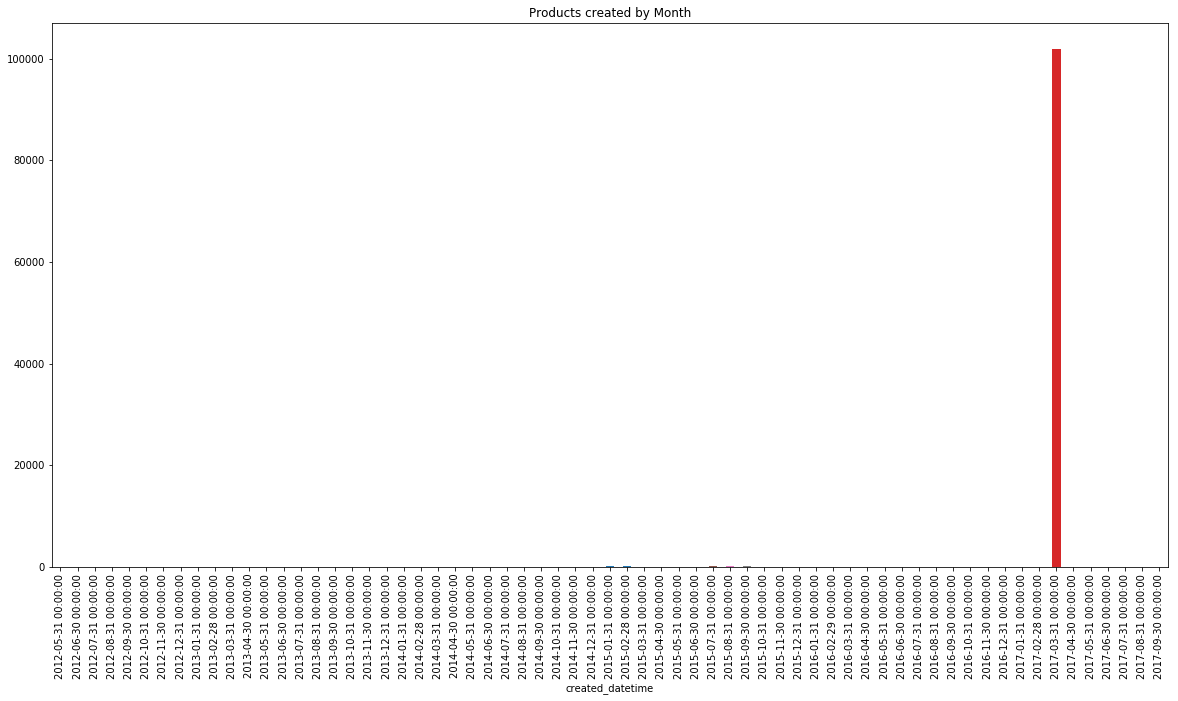

In [66]:
# Amount of Products created each month
products_per_month.plot(kind='bar', figsize=(20,10), title='Products created by Month')

plt.show()

We can see that the vast majority of our entries in our data were made at the same time (or at least date).

In [67]:
mean_products_per_month = products_per_month.groupby(products_per_month.index.month).mean()

In [68]:
mean_products_per_month

created_datetime
1       33.000
2       22.400
3    20398.200
4       12.200
5        4.667
6        5.667
7       28.167
8       18.833
9       14.000
10       6.400
11       9.800
12       8.200
Name: product_name, dtype: float64

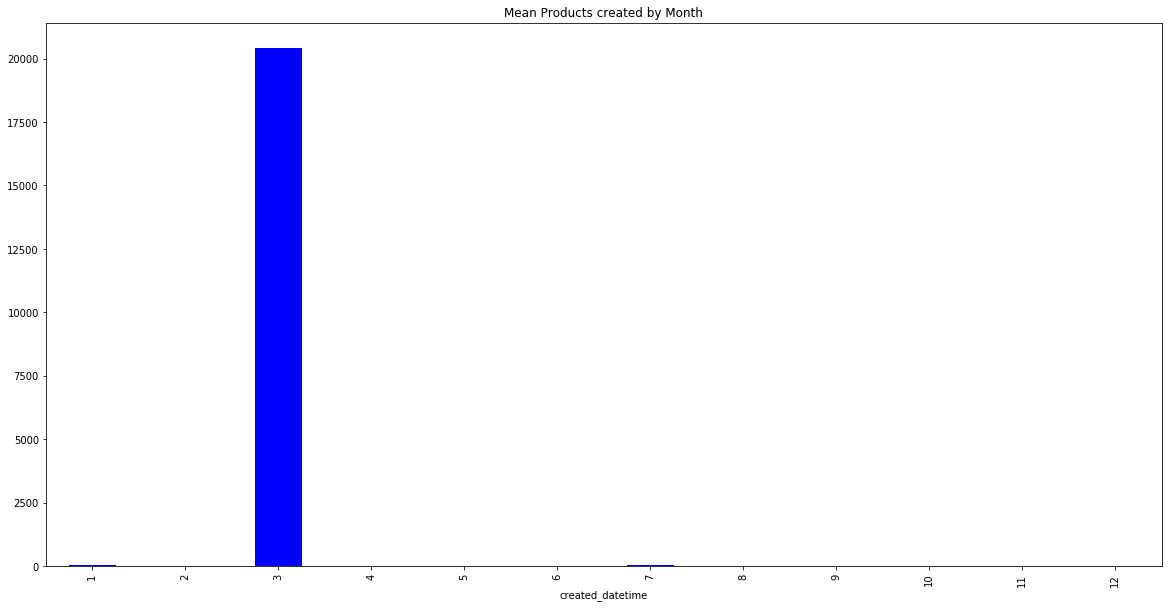

In [69]:
# Mean amount of Product created by month
mean_products_per_month.plot(kind='bar', figsize=(20,10), color='blue', title='Mean Products created by Month')

plt.show()

Since most of our data is from the same time period it doesn't make much sense to track the development of variables over time.

In [70]:
data.set_index('code', inplace=True)

#### Most common Addatives
<a id="mca" > 

In [71]:
print('There are {:,} unique additives in our data'.format(data_exp_additives['additives_exp'].dropna().unique().shape[0]))

There are 314 unique additives in our data


In [72]:
print('These are the 10 most common additives in our data:\n{}'.format(data_exp_additives['additives_exp'].value_counts().head(10)))

These are the 10 most common additives in our data:
E101 - Riboflavin           17082
E375 - Nicotinic acid       17078
E101i - Riboflavin          17076
E330 - Citric acid          16674
E322 - Lecithins            13301
E322i - Lecithin            13279
E415 - Xanthan gum           6737
E412 - Guar gum              6097
E339 - Sodium phosphates     5089
E407 - Carrageenan           4839
Name: additives_exp, dtype: int64


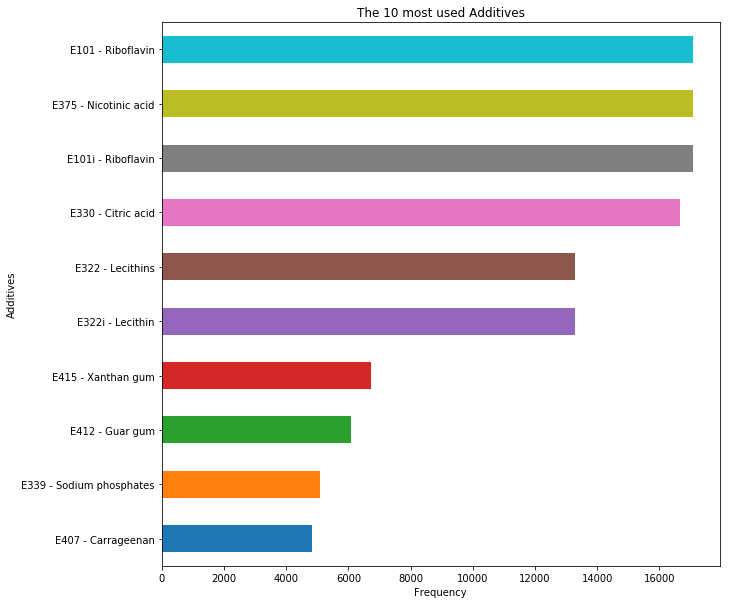

In [73]:
data_exp_additives['additives_exp'].value_counts().head(10).sort_values().plot(kind='barh', figsize=(10,10))
plt.xlabel('Frequency')
plt.ylabel('Additives')
plt.title('The 10 most used Additives')

plt.show()

#### Most common Addatives
<a id="mca" > 

In [74]:
print('There are {:,} unique ingredients in our data'.format(data_exp_ingredients['ingredients_exp'].dropna().unique().shape[0]))

There are 123,069 unique ingredients in our data


In [75]:
print('Thesee are five most common ingredients in our data:\n{}'.format(data_exp_ingredients['ingredients_exp'].value_counts().head(5)))

Thesee are five most common ingredients in our data:
 salt          53071
 sugar         36870
 water         33291
 niacin        15037
 riboflavin    13555
Name: ingredients_exp, dtype: int64


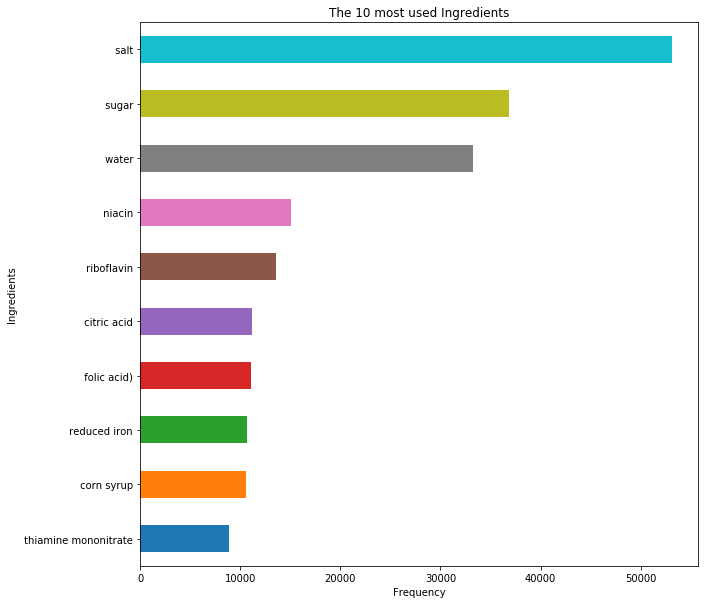

In [76]:
data_exp_ingredients['ingredients_exp'].value_counts().head(10).sort_values().plot(kind='barh', figsize=(10,10))
plt.xlabel('Frequency')
plt.ylabel('Ingredients')
plt.title('The 10 most used Ingredients')

plt.show()

### Characteristics
<a id="cha" >

### Characteristics of Categories
<a id="coc" >

In [77]:
data_exp_categories.reset_index(inplace=True)

In [78]:
print("There are {:,} unique categories in our data".format(data_exp_categories['categories_exp'].dropna().unique().shape[0]))

There are 503 unique categories in our data


In [79]:
print('Thesee are five most common categories in our data:\n{}'.format(data_exp_categories['categories_exp'].value_counts().head(5)))

Thesee are five most common categories in our data:
Plant-based foods and beverages    351
Plant-based foods                  346
Sugary snacks                      247
Cereals and potatoes               244
Groceries                          237
Name: categories_exp, dtype: int64


In [80]:
# Excluding Categories that appear less then 10 times in our data.
categories_filtered = data_exp_categories.groupby('categories_exp').filter(lambda x: len(x) >= 10)

In [81]:
# We group this dataframe by their categories
categories_grouped = categories_filtered.groupby('categories_exp')

In [82]:
categories_grouped.describe().head(20)

additives_n                                           calcium_100g                                           carbohydrates_100g                                                  cholesterol_100g  ...          time_delta trans_fat_100g                                           vitamin_a_100g                                           vitamin_c_100g                                          
                                 count  mean   std   min   25%   50%   75%   max        count  mean   std   min   25%   50%   75%   max              count   mean    std    min    25%    50%    75%    max            count  ...                 max          count  mean   std   min   25%   50%   75%   max          count  mean   std   min   25%   50%   75%   max          count  mean   std   min   25%   50%   75%   max
categories_exp                                                                                                                                                                                                                ...                                                                                                                                                                                               
Appetizers                      42.000 2.071 1.879 0.000 0.000 2.000 3.000 7.000       42.000 0.048 0.071 0.000 0.000 0.000 0.071 0.271             42.000 65.392 11.386 22.500 60.700 66.700 73.300 83.300           42.000  ...   -1 days +23:45:09         42.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000         42.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000         42.000 0.007 0.015 0.000 0.000 0.000 0.006 0.086
Bars                            15.000 1.600 2.063 0.000 0.000 1.000 2.000 6.000       15.000 0.143 0.124 0.000 0.049 0.100 0.184 0.391             15.000 51.695 15.103 16.000 40.380 55.260 63.500 68.600           15.000  ...   -1 days +23:50:50         15.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000         15.000 0.000 0.000 0.000 0.000 0.000 0.000 0.001         15.000 0.007 0.020 0.000 0.000 0.000 0.003 0.079
Beverages                       28.000 2.536 1.915 0.000 1.000 2.000 5.000 5.000       28.000 0.099 0.077 0.000 0.011 0.122 0.167 0.190             28.000  5.655  4.077  0.400  2.733  4.205  9.385 15.000           28.000  ...   -1 days +23:51:30         28.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000         28.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000         28.000 0.002 0.006 0.000 0.000 0.000 0.001 0.030
Biscuits                        48.000 3.062 1.791 0.000 1.750 3.000 4.000 7.000       48.000 0.029 0.069 0.000 0.000 0.000 0.030 0.429             48.000 66.159  8.185 42.300 63.075 67.800 71.025 80.000           48.000  ...   -1 days +23:45:52         48.000 0.005 0.026 0.000 0.000 0.000 0.000 0.158         48.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000         48.000 0.001 0.004 0.000 0.000 0.000 0.000 0.028
Biscuits and cakes              57.000 3.193 1.913 0.000 2.000 3.000 4.000 9.000       57.000 0.034 0.076 0.000 0.000 0.000 0.035 0.429             57.000 62.948 12.644 21.700 59.300 66.700 70.600 80.000           57.000  ...   -1 days +23:53:50         57.000 0.021 0.095 0.000 0.000 0.000 0.000 0.667         57.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000         57.000 0.001 0.004 0.000 0.000 0.000 0.000 0.028
Breads                         151.000 3.073 2.353 0.000 2.000 2.000 3.000 9.000      151.000 0.104 0.073 0.000 0.040 0.103 0.138 0.400            151.000 50.020  5.561 15.000 47.655 50.650 52.665 62.500          151.000  ...   -1 days +23:50:18        151.000 0.006 0.072 0.000 0.000 0.000 0.000 0.880        151.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000        151.000 0.001 0.003 0.000 0.000 0.000 0.000 0.021
Breakfast cereals               32.000 2.625 2.311 0.000 1.000 2.000 4.000 8.000       32.000 0.137 0.164 0.000 0.000 0.040 0.325 0.385             32.000 80.610  7.542 59.400 78.450 81.550 85.575 89.700           32.000  ...   -1 days +23:50:28         32.000 0.000 0.000 0

In [83]:
fat_top_ten = categories_grouped['fat_100g'].describe().sort_values(by='mean',ascending=False).head(10)
fat_top_ten

,count,mean,std,min,25%,50%,75%,max
categories_exp,,,,,,,,
Oilseed purees,24.000,49.206,3.443,35.290,49.625,50.000,50.000,53.330
Nut butters,23.000,49.171,3.516,35.290,49.250,50.000,50.000,53.330
Peanut butters,18.000,48.583,3.684,35.290,47.300,50.000,50.000,53.120
Legume butters,18.000,48.583,3.684,35.290,47.300,50.000,50.000,53.120
Plant-based spreads,28.000,44.630,12.551,0.000,46.900,50.000,50.000,53.330
Spreads,35.000,40.434,15.240,0.000,32.400,50.000,50.000,53.330
Nuts and their products,38.000,39.872,19.135,1.040,44.075,50.000,50.000,53.600
Milk chocolates,13.000,34.428,4.070,30.000,31.000,32.970,36.800,42.500
Dark chocolates,10.000,32.940,1.896,31.100,31.600,32.500,33.300,36.400


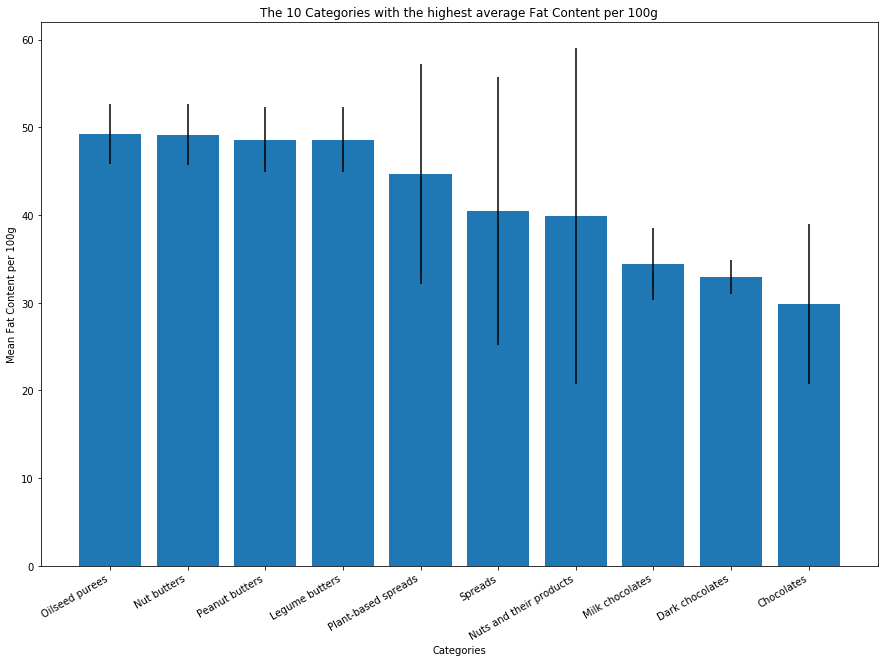

In [84]:
index = fat_top_ten.index
mean = fat_top_ten['mean'] 
std = fat_top_ten['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Categories")
plt.ylabel("Mean Fat Content per 100g")
plt.title("The 10 Categories with the highest average Fat Content per 100g")
plt.xticks(x_pos, index, rotation=30, horizontalalignment="right")


plt.show()

In [85]:
protein_top_ten = categories_grouped['proteins_100g'].describe().sort_values(by='mean', ascending=False).head(10)
protein_top_ten

,count,mean,std,min,25%,50%,75%,max
categories_exp,,,,,,,,
Legume butters,18.000,22.303,1.669,18.800,21.885,21.900,21.900,25.000
Peanut butters,18.000,22.303,1.669,18.800,21.885,21.900,21.900,25.000
Fishes,10.000,21.817,5.126,11.400,18.425,23.100,25.650,28.570
Oilseed purees,24.000,21.031,3.313,12.500,21.047,21.900,21.900,25.000
Nut butters,23.000,20.994,3.383,12.500,20.895,21.900,21.900,25.000
Seafood,12.000,19.726,7.407,2.040,17.400,21.350,24.550,28.570
Plant-based spreads,28.000,18.754,6.550,0.000,17.562,21.880,21.900,25.000
Meats,21.000,16.893,4.497,10.000,12.700,17.600,19.100,26.000
Nuts and their products,38.000,16.836,8.675,0.400,13.543,21.540,21.900,28.100


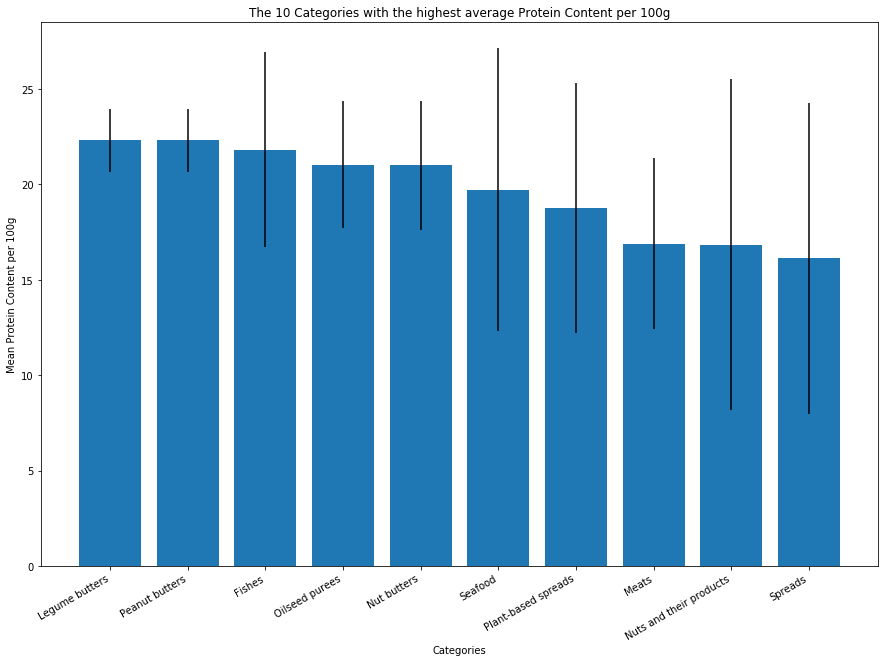

In [86]:
index = protein_top_ten.index
mean = protein_top_ten['mean'] 
std = protein_top_ten['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Categories")
plt.ylabel("Mean Protein Content per 100g")
plt.title("The 10 Categories with the highest average Protein Content per 100g")
plt.xticks(x_pos, index, rotation=30, horizontalalignment="right")


plt.show()

In [87]:
carbs_top_ten = categories_grouped['carbohydrates_100g'].describe().sort_values(by='mean',ascending=False).head(10)
carbs_top_ten

,count,mean,std,min,25%,50%,75%,max
categories_exp,,,,,,,,
Breakfast cereals,32.000,80.610,7.542,59.400,78.450,81.550,85.575,89.700
Cereals and their products,93.000,71.738,17.227,3.570,71.400,75.000,80.600,89.700
Pastas,41.000,71.080,9.664,29.900,72.000,73.200,75.000,89.100
Breakfasts,47.000,71.043,19.605,18.800,66.600,78.800,84.500,89.700
Crackers,28.000,69.742,7.896,50.000,63.900,71.400,73.725,83.300
Biscuits,48.000,66.159,8.185,42.300,63.075,67.800,71.025,80.000
Cookies,35.000,65.523,8.325,42.300,62.950,65.400,70.300,80.000
Appetizers,42.000,65.392,11.386,22.500,60.700,66.700,73.300,83.300
Candies,21.000,63.514,19.506,20.000,58.800,67.600,73.700,92.500


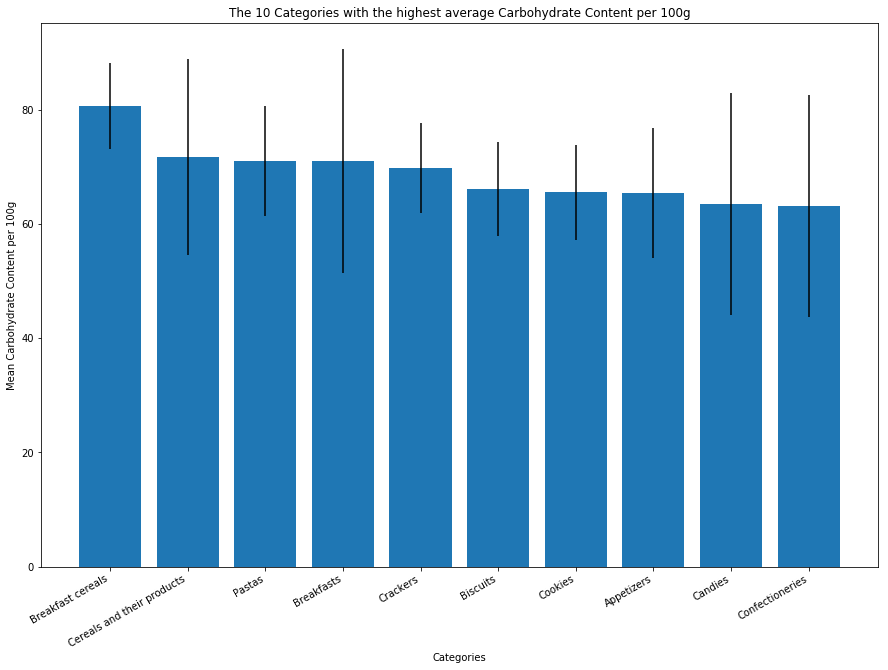

In [88]:
index = carbs_top_ten.index
mean = carbs_top_ten['mean'] 
std = carbs_top_ten['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Categories")
plt.ylabel("Mean Carbohydrate Content per 100g")
plt.title("The 10 Categories with the highest average Carbohydrate Content per 100g")
plt.xticks(x_pos, index, rotation=30, horizontalalignment="right")


plt.show()

In [89]:
sugar_top_10 = categories_grouped['sugars_100g'].describe().sort_values(by='mean',ascending=False).head(10)
sugar_top_10

,count,mean,std,min,25%,50%,75%,max
categories_exp,,,,,,,,
Candies,21.000,49.024,14.771,15.000,45.000,51.300,58.500,70.000
Milk chocolates,13.000,48.958,7.307,33.300,46.000,50.000,52.500,60.000
Confectioneries,24.000,46.662,16.032,15.000,41.700,50.000,57.750,70.000
Chocolates,38.000,46.331,10.776,15.000,42.125,47.450,51.875,65.000
Dark chocolates,10.000,45.050,4.210,36.400,42.700,45.700,47.475,51.100
Cookies,35.000,33.521,7.838,16.700,27.650,35.300,39.400,46.670
Biscuits,48.000,32.495,9.864,0.000,25.375,35.100,39.625,49.700
Bars,15.000,31.134,14.848,8.000,23.620,28.120,33.975,60.000
Biscuits and cakes,57.000,31.010,10.893,0.000,22.600,32.400,39.300,49.700


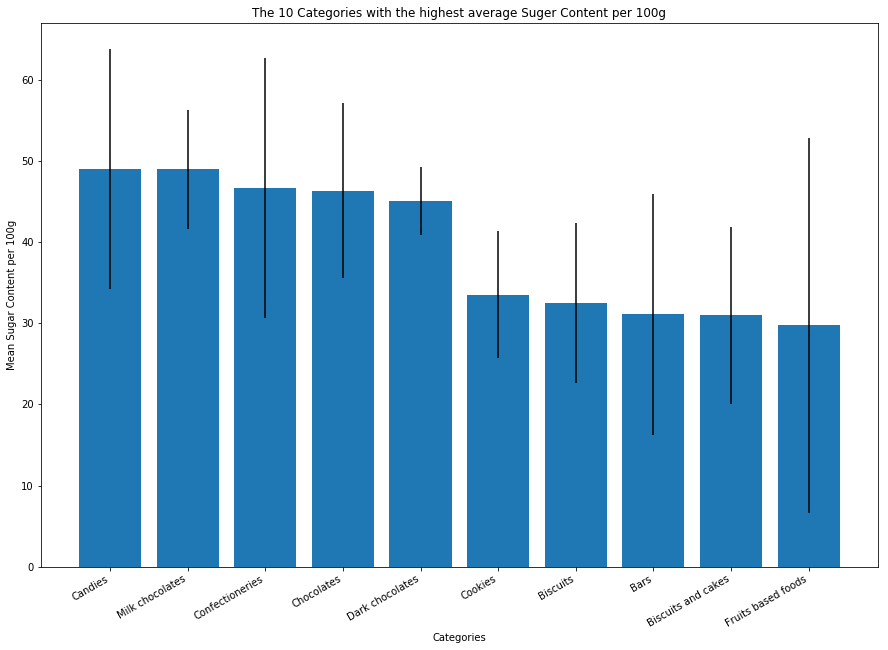

In [90]:
index = sugar_top_10.index
mean = sugar_top_10['mean'] 
std = sugar_top_10['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Categories")
plt.ylabel("Mean Sugar Content per 100g")
plt.title("The 10 Categories with the highest average Suger Content per 100g")
plt.xticks(x_pos, index, rotation=30, horizontalalignment="right")


plt.show()

In [91]:
un_healthy_top_10 = categories_grouped['nutrition_score_100g'].describe().sort_values(by='mean',ascending=False).head(10)
un_healthy_top_10

,count,mean,std,min,25%,50%,75%,max
categories_exp,,,,,,,,
Milk chocolates,13.000,22.923,1.935,18.000,23.000,23.000,24.000,26.000
Dark chocolates,10.000,21.000,1.944,19.000,20.250,21.000,21.000,26.000
Chocolates,38.000,20.737,3.888,11.000,19.000,21.000,23.000,27.000
Candies,21.000,19.333,6.522,4.000,14.000,22.000,23.000,27.000
Biscuits,48.000,18.625,5.085,8.000,16.000,19.000,22.250,29.000
Cookies,35.000,18.571,5.175,8.000,16.000,19.000,22.000,29.000
Confectioneries,24.000,18.500,7.108,4.000,13.500,22.000,23.000,27.000
Biscuits and cakes,57.000,17.912,5.309,5.000,15.000,19.000,22.000,29.000
Sugary snacks,247.000,16.320,6.176,-6.000,12.000,18.000,21.000,29.000


In [92]:
healthy_top_10 = categories_grouped['nutrition_score_100g'].describe().sort_values(by='mean',ascending=True).head(10)
healthy_top_10

,count,mean,std,min,25%,50%,75%,max
categories_exp,,,,,,,,
Vegetables based foods,19.000,-4.684,4.256,-10.000,-7.000,-6.000,-3.500,5.000
Canned vegetables,13.000,-4.231,4.816,-10.000,-7.000,-6.000,-4.000,5.000
Canned plant-based foods,27.000,-4.111,3.479,-10.000,-6.000,-5.000,-3.000,5.000
Fruits and vegetables based foods,33.000,-3.364,4.159,-10.000,-6.000,-4.000,0.000,5.000
Pastas,41.000,-2.220,6.758,-6.000,-6.000,-6.000,-2.000,17.000
Fruits based foods,13.000,-1.846,3.363,-7.000,-4.000,-3.000,0.000,4.000
Canned foods,39.000,-1.641,5.617,-10.000,-6.000,-3.000,2.000,19.000
Seeds,11.000,-1.545,4.783,-7.000,-4.500,-2.000,-0.500,11.000
Greek yogurts,16.000,-1.375,2.363,-5.000,-2.000,-1.000,-1.000,5.000


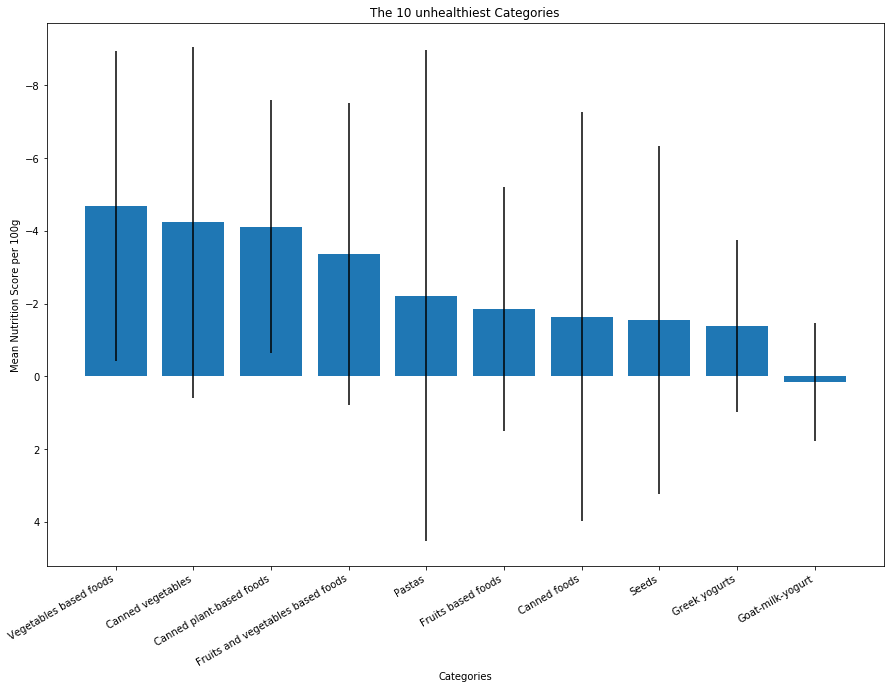

In [93]:
index = healthy_top_10.index
mean = healthy_top_10['mean'] 
std = healthy_top_10['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Categories")
plt.ylabel("Mean Nutrition Score per 100g")
plt.title("The 10 unhealthiest Categories")
plt.xticks(x_pos, index, rotation=30, horizontalalignment="right")
plt.gca().invert_yaxis()



plt.show()

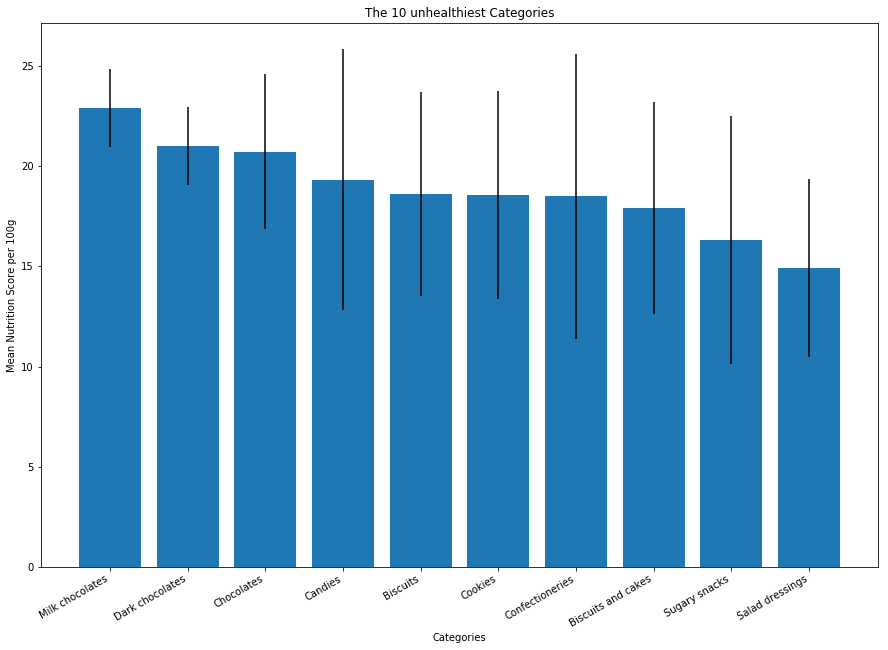

In [94]:
index = un_healthy_top_10.index
mean = un_healthy_top_10['mean'] 
std = un_healthy_top_10['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Categories")
plt.ylabel("Mean Nutrition Score per 100g")
plt.title("The 10 unhealthiest Categories")
plt.xticks(x_pos, index, rotation=30, horizontalalignment="right")


plt.show()

### Characteristics of Countries
<a id="dbc" >

In [95]:
print("There are {:,} unique countries in our data".format(data_exp_countries['countries_exp'].dropna().unique().shape[0]))

There are 20 unique countries in our data


In [96]:
print('This is the how often each Country appears in our data: \n{}'.format(data_exp_countries['countries_exp'].value_counts())) 

This is the how often each Country appears in our data: 
United States                102759
Canada                           99
France                           89
United Kingdom                   12
Switzerland                      10
Australia                         6
Spain                             4
Belgium                           4
Saint Pierre and Miquelon         2
Tunisia                           2
Germany                           2
Singapore                         2
Hong Kong                         1
Denmark                           1
Netherlands                       1
Italy                             1
Malaysia                          1
Nederland                         1
Colombia                          1
Russia                            1
Name: countries_exp, dtype: int64


In [97]:
# We will focus on The US, France and Canada since there is just not enough data for all the other Countries
data_exp_countries = data_exp_countries[(data_exp_countries['countries_exp']=='United States')|
                                        (data_exp_countries['countries_exp']=='France')|
                                        (data_exp_countries['countries_exp']=='Canada')]

In [98]:
countries_grouped = data_exp_countries.groupby('countries_exp')

In [99]:
countries_grouped.describe()

additives_n                                           calcium_100g                                           carbohydrates_100g                                                  cholesterol_100g  ...          time_delta trans_fat_100g                                           vitamin_a_100g                                           vitamin_c_100g                                          
                    count  mean   std   min   25%   50%   75%   max        count  mean   std   min   25%   50%   75%   max              count   mean    std   min    25%    50%    75%     max            count  ...                 max          count  mean   std   min   25%   50%   75%   max          count  mean   std   min   25%   50%   75%   max          count  mean   std   min   25%   50%   75%   max
countries_exp                                                                                                                                                                                                    ...                                                                                                                                                                                               
Canada             99.000 2.071 2.042 0.000 0.000 2.000 4.000 7.000       99.000 0.060 0.072 0.000 0.000 0.033 0.100 0.333             99.000 29.978 25.523 0.000  7.405 22.500 51.000  82.800           99.000  ...   -1 days +23:50:55         99.000 0.067 0.196 0.000 0.000 0.000 0.000 1.330         99.000 0.000 0.000 0.000 0.000 0.000 0.000 0.001         99.000 0.003 0.008 0.000 0.000 0.000 0.001 0.053
France             89.000 1.753 1.866 0.000 0.000 1.000 2.000 9.000       89.000 0.078 0.108 0.000 0.000 0.040 0.108 0.533             89.000 42.124 28.603 0.000 13.100 50.800 64.290  89.700           89.000  ...   -1 days +20:30:50         89.000 0.009 0.048 0.000 0.000 0.000 0.000 0.320         89.000 0.000 0.000 0.000 0.000 0.000 0.000 0.001         89.000 0.005 0.012 0.000 0.000 0.000 0.002 0.063
United States  102759.000 1.890 2.053 0.000 0.000 1.000 3.000 9.000   102759.000 0.061 0.088 0.000 0.000 0.031 0.090 0.595         102759.000 35.549 27.417 0.000 10.000 28.300 60.710 100.000       102759.000  ...     0 days 00:00:00     102759.000 0.013 0.139 0.000 0.000 0.000 0.000 2.780     102759.000 0.000 0.000 0.000 0.000 0.000 0.000 0.001     102759.000 0.005 0.017 0.000 0.000 0.000 0.003 0.341

[3 rows x 160 columns]

In [100]:
country_fat_top_ten = countries_grouped['fat_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_fat_top_ten

,count,mean,std,min,25%,50%,75%,max
countries_exp,,,,,,,,
France,89.000,13.728,13.663,0.000,1.410,10.000,21.430,50.000
United States,102759.000,11.842,13.470,0.000,0.780,6.670,20.000,58.060
Canada,99.000,10.206,11.738,0.000,1.250,5.430,16.700,48.400


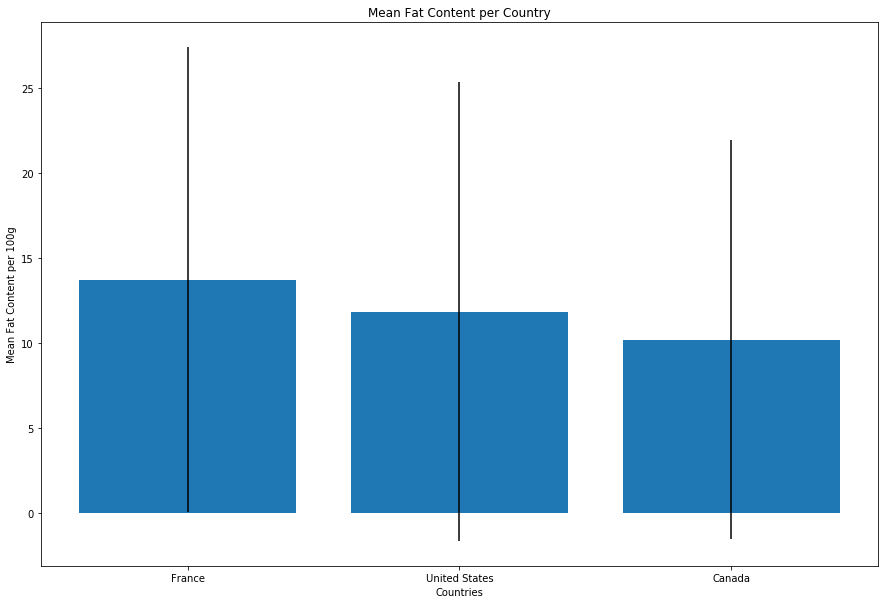

In [101]:
index = country_fat_top_ten.index
mean = country_fat_top_ten['mean'] 
std = country_fat_top_ten['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Countries")
plt.ylabel("Mean Fat Content per 100g")
plt.title("Mean Fat Content per Country")
plt.xticks(x_pos, index)


plt.show()

In [102]:
country_carbs_top_ten = countries_grouped['carbohydrates_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_carbs_top_ten

,count,mean,std,min,25%,50%,75%,max
countries_exp,,,,,,,,
France,89.000,42.124,28.603,0.000,13.100,50.800,64.290,89.700
United States,102759.000,35.549,27.417,0.000,10.000,28.300,60.710,100.000
Canada,99.000,29.978,25.523,0.000,7.405,22.500,51.000,82.800


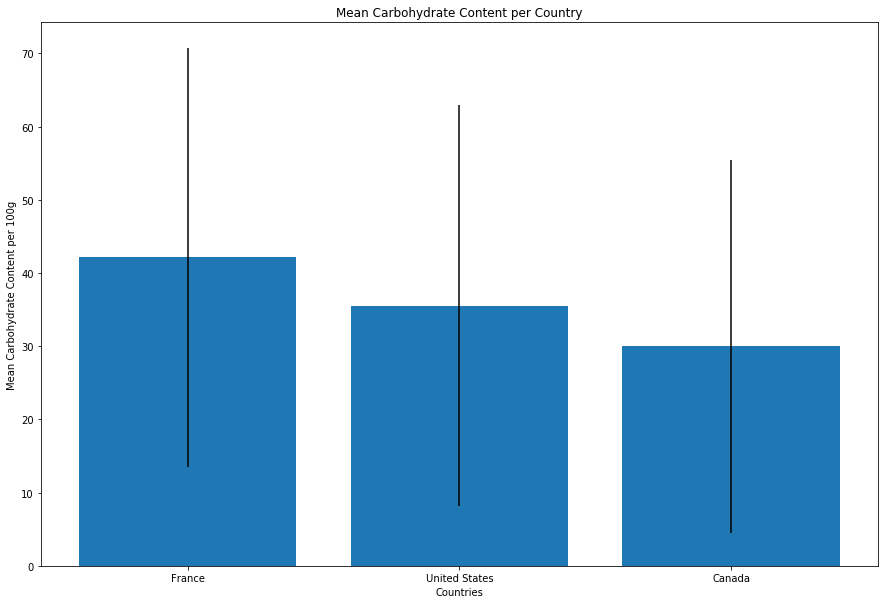

In [103]:
index = country_carbs_top_ten.index
mean = country_carbs_top_ten['mean'] 
std = country_carbs_top_ten['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Countries")
plt.ylabel("Mean Carbohydrate Content per 100g")
plt.title("Mean Carbohydrate Content per Country")
plt.xticks(x_pos, index)


plt.show()

In [104]:
country_protein_top_ten = countries_grouped['proteins_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_protein_top_ten

,count,mean,std,min,25%,50%,75%,max
countries_exp,,,,,,,,
France,89.000,7.178,6.557,0.000,2.350,5.410,9.520,26.420
United States,102759.000,6.838,6.288,0.000,2.330,5.130,10.000,31.580
Canada,99.000,6.474,5.521,0.000,2.650,5.000,9.650,26.000


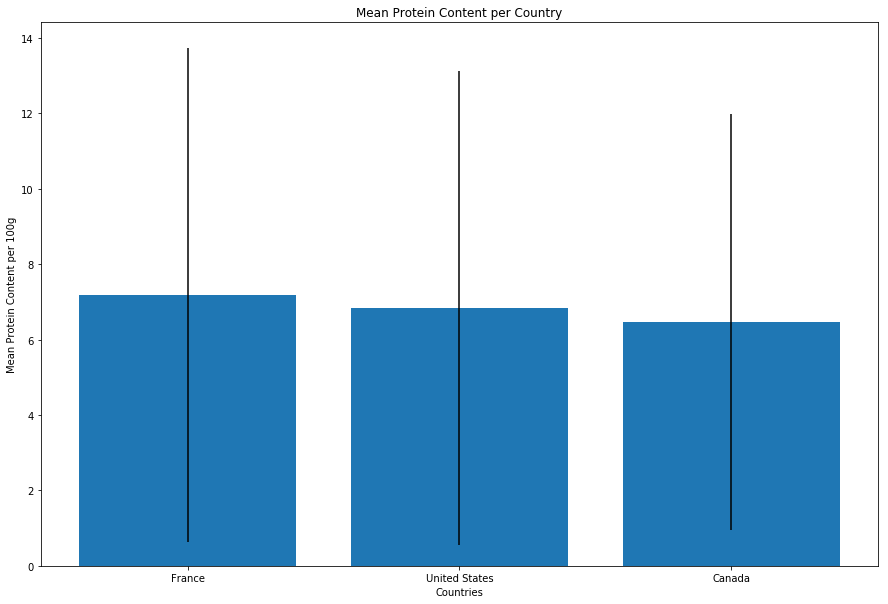

In [105]:
index = country_protein_top_ten.index
mean = country_protein_top_ten['mean'] 
std = country_protein_top_ten['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Countries")
plt.ylabel("Mean Protein Content per 100g")
plt.title("Mean Protein Content per Country")
plt.xticks(x_pos, index)


plt.show()

In [106]:
country_sugar_top_ten = countries_grouped['sugars_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_sugar_top_ten

,count,mean,std,min,25%,50%,75%,max
countries_exp,,,,,,,,
France,89.000,18.131,18.418,0.000,3.000,10.000,34.000,65.000
United States,102759.000,14.958,17.861,0.000,2.040,6.430,23.810,73.330
Canada,99.000,13.272,16.886,0.000,1.055,6.670,20.000,65.000


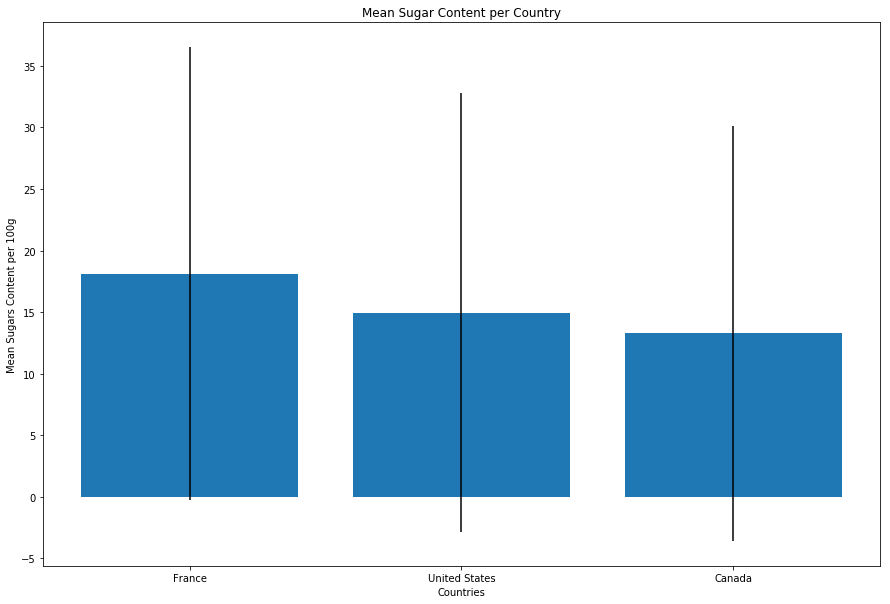

In [107]:
index = country_sugar_top_ten.index
mean = country_sugar_top_ten['mean'] 
std = country_sugar_top_ten['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Countries")
plt.ylabel("Mean Sugars Content per 100g")
plt.title("Mean Sugar Content per Country")
plt.xticks(x_pos, index)


plt.show()

In [108]:
country_healthy_top_10 = countries_grouped['nutrition_score_100g'].describe().sort_values(by='mean',ascending=True).head(10)
country_healthy_top_10

,count,mean,std,min,25%,50%,75%,max
countries_exp,,,,,,,,
Canada,99.000,6.212,8.471,-9.000,0.000,4.000,12.000,25.000
United States,102759.000,8.402,8.835,-10.000,1.000,8.000,15.000,34.000
France,89.000,10.573,9.060,-8.000,2.000,12.000,18.000,29.000


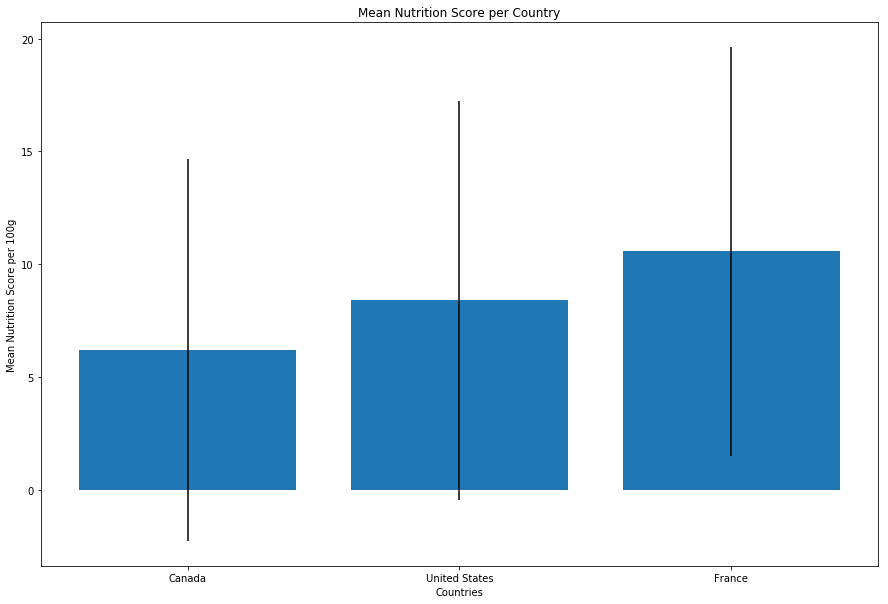

In [109]:
index = country_healthy_top_10.index
mean = country_healthy_top_10['mean'] 
std = country_healthy_top_10['std']

plt.figure(figsize=(15,10))
x_pos = [i for i, _ in enumerate(index)]
plt.figsize=(20,10)
plt.bar(x_pos, mean, yerr=std)
plt.xlabel("Countries")
plt.ylabel("Mean Nutrition Score per 100g")
plt.title("Mean Nutrition Score per Country")
plt.xticks(x_pos, index)

plt.show()

### Relationships
<a id="rel" > 

We will now look at pair-plots of the variables 'energy_100g' and 'nutrition_score_100g' with all other numeric variables. As hue we will us the categorical variables 'nutrition_grafe_fr'.

#### Relationships: nutrition_score_100g
<a id="rns" > 

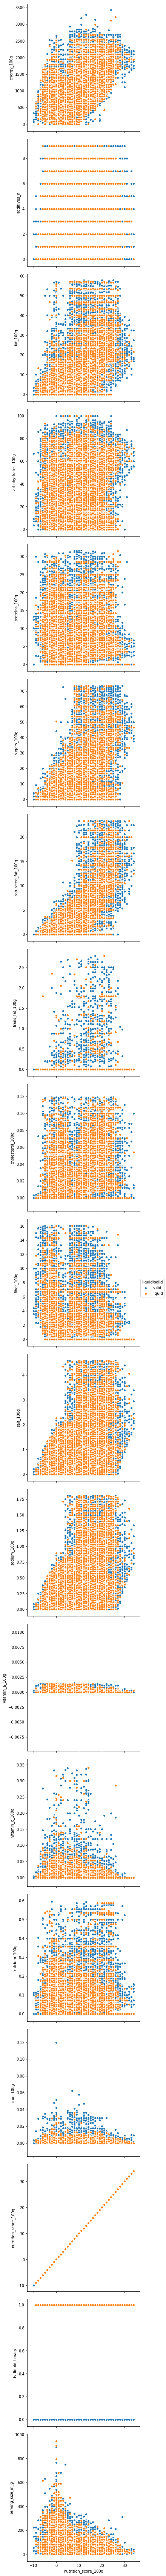

In [110]:
sns.pairplot(data, size=5, hue='liquid/solid',
            x_vars=['nutrition_score_100g'],
            y_vars= ['energy_100g', 'additives_n', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'sugars_100g',
                      'saturated_fat_100g', 'trans_fat_100g', 'cholesterol_100g', 'fiber_100g', 
                     'salt_100g', 'sodium_100g', 'vitamin_a_100g', 'vitamin_c_100g', 'calcium_100g', 
                     'iron_100g', 'nutrition_score_100g','is_liquid_binary', 'serving_size_in_g'])

plt.show()

There seems to be a (loosly linear) relationship with the variables: fat_100g, sugars_100g, suturated_fat_100g, sodium_100g and salt_100g.
Solid datapoints are primarely visible on the edges. 

#### Relationships: energy_100g
<a id="re" > 

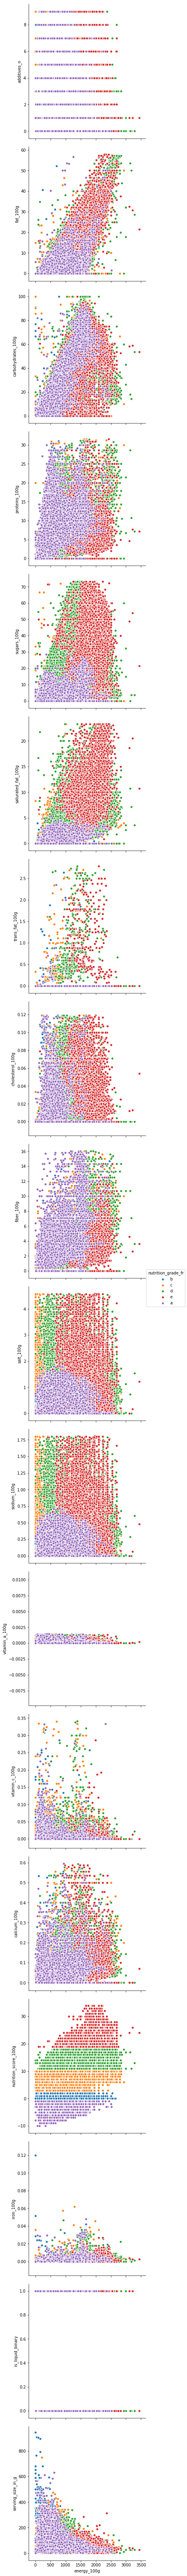

In [111]:
sns.pairplot(data, size=5, hue='nutrition_grade_fr',
            x_vars=['energy_100g'],
            y_vars= ['additives_n', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'sugars_100g',
                      'saturated_fat_100g', 'trans_fat_100g', 'cholesterol_100g', 'fiber_100g', 
                     'salt_100g', 'sodium_100g', 'vitamin_a_100g', 'vitamin_c_100g', 'calcium_100g', 
                     'nutrition_score_100g','iron_100g', 'is_liquid_binary', 'serving_size_in_g'])

plt.show()

We can clearly seee that the 'nutrition_grade_fr' variable is derived from clear cut-off values from the 'nutrition_score_100g' variable.  
The much more interesting thing however, is that we can see some clear clusters of categories in the energy pair-plots.


### Correlations
<a id="corr" > 

In [112]:
data.corr(method = "pearson")

,additives_n,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_100g,is_liquid_binary,serving_size_in_g
additives_n,1.000,0.031,-0.091,0.036,0.023,0.080,0.162,0.185,-0.220,-0.107,0.117,0.117,0.003,-0.021,0.064,0.036,0.208,-0.036,-0.049
energy_100g,0.031,1.000,0.771,0.568,0.029,0.017,0.671,0.399,0.448,0.396,0.151,0.151,-0.121,-0.121,0.143,0.300,0.643,-0.171,-0.586
fat_100g,-0.091,0.771,1.000,0.691,0.031,0.181,0.081,0.097,0.312,0.410,0.184,0.184,-0.086,-0.119,0.201,0.114,0.602,-0.087,-0.384
saturated_fat_100g,0.036,0.568,0.691,1.000,0.053,0.374,0.127,0.323,0.036,0.179,0.060,0.060,-0.023,-0.133,0.233,0.023,0.743,-0.106,-0.283
trans_fat_100g,0.023,0.029,0.031,0.053,1.000,0.081,0.003,0.024,-0.043,0.021,0.015,0.015,-0.012,-0.021,0.003,-0.005,0.066,-0.013,0.008
cholesterol_100g,0.080,0.017,0.181,0.374,0.081,1.000,-0.258,-0.082,-0.301,0.319,0.189,0.189,0.066,-0.109,0.198,-0.109,0.286,0.036,-0.022
carbohydrates_100g,0.162,0.671,0.081,0.127,0.003,-0.258,1.000,0.599,0.335,-0.017,-0.028,-0.028,-0.085,-0.035,-0.048,0.322,0.356,-0.182,-0.474
sugars_100g,0.185,0.399,0.097,0.323,0.024,-0.082,0.599,1.000,-0.001,-0.249,-0.243,-0.243,-0.053,-0.003,-0.012,0.055,0.575,-0.178,-0.294
fiber_100g,-0.220,0.448,0.312,0.036,-0.043,-0.301,0.335,-0.001,1.000,0.362,-0.038,-0.038,-0.017,-0.008,0.117,0.360,-0.104,-0.137,-0.273
proteins_100g,-0.107,0.396,0.410,0.179,0.021,0.319,-0.017,-0.249,0.362,1.000,0.228,0.228,-0.074,-0.132,0.305,0.224,0.049,-0.004,-0.214


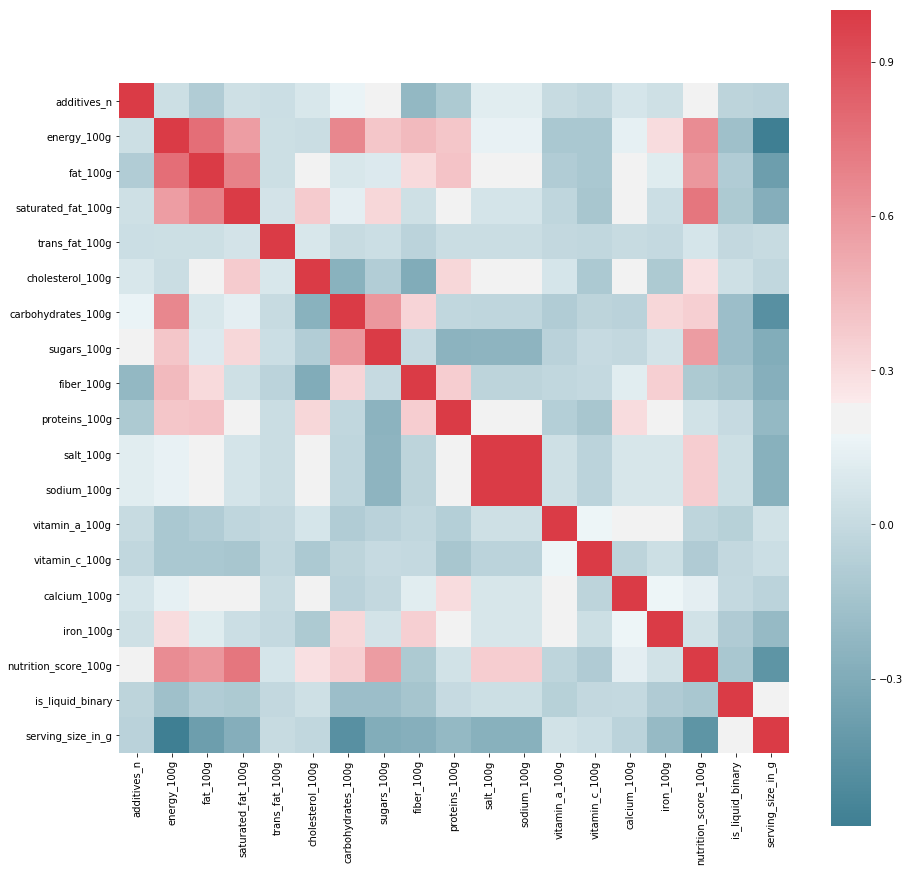

In [113]:
corr = data.corr(method = "pearson")

f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

In [114]:
# Source: https://code.i-harness.com/en/q/10f46da
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [115]:
print('The top 5 Correlations between variables are: \n{}'.format(get_top_abs_correlations(data.select_dtypes(include=float), n=5)))

The top 5 Correlations between variables are: 
salt_100g           sodium_100g            1.000
energy_100g         fat_100g               0.771
saturated_fat_100g  nutrition_score_100g   0.743
fat_100g            saturated_fat_100g     0.691
energy_100g         carbohydrates_100g     0.671
dtype: float64


### Regression
<a id="reg" > 

In [116]:
# We exclude the variable 'sodium_100g' for our regression since it is so highly correlated with 'salt_100g'
energy_regression = sm.ols(formula= """energy_100g ~ additives_n
                                   + fat_100g
                                   + fiber_100g
                                   + saturated_fat_100g
                                   + trans_fat_100g
                                   + cholesterol_100g
                                   + carbohydrates_100g
                                   + sugars_100g
                                   + proteins_100g
                                   + salt_100g
                                   + vitamin_a_100g
                                   + vitamin_c_100g
                                   + calcium_100g
                                   + iron_100g
                                   + nutrition_score_100g
                                   + is_liquid_binary
                                   + serving_size_in_g""", data = stand_data)
res = energy_regression.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            energy_100g   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 3.812e+05
Date:                Sat, 25 Aug 2018   Prob (F-statistic):               0.00
Time:                        22:56:20   Log-Likelihood:                 67950.
No. Observations:              102879   AIC:                        -1.359e+05
Df Residuals:                  102861   BIC:                        -1.357e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             7.649e-15 

As you would expect, the main drivers of energy_100g seem to be fat_100g and carbohydrates_100g. This makes sense since fat has the most amount of energy per gram. Proteins seem to affect the energy content of food to a significantly lesser degree. It should be noted however that sugars_100g seems to have a negative impact on the overall energy content of a product. This is an effect that should be further investigated. The only two variables that are not statistically significant are vitamin_c_100g and is_liquid_binary. 

In [117]:
nutrition_score_regression = sm.ols(formula= """nutrition_score_100g ~ additives_n
                                   + energy_100g
                                   + fat_100g
                                   + fiber_100g
                                   + saturated_fat_100g
                                   + trans_fat_100g
                                   + cholesterol_100g
                                   + carbohydrates_100g
                                   + sugars_100g
                                   + proteins_100g
                                   + salt_100g
                                   + vitamin_a_100g
                                   + vitamin_c_100g
                                   + calcium_100g
                                   + iron_100g
                                   + is_liquid_binary
                                   + serving_size_in_g""", data = stand_data)
res = nutrition_score_regression.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     nutrition_score_100g   R-squared:                       0.922
Model:                              OLS   Adj. R-squared:                  0.922
Method:                   Least Squares   F-statistic:                 7.153e+04
Date:                  Sat, 25 Aug 2018   Prob (F-statistic):               0.00
Time:                          22:56:21   Log-Likelihood:                -14750.
No. Observations:                102879   AIC:                         2.954e+04
Df Residuals:                    102861   BIC:                         2.971e+04
Df Model:                            17                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

The variables that impact the health_score_100g (negatively) the most are sugars_100g, salt_100g and saturated_fat_100g. Interestingly carbohydrates seem to have a (slightly) positive impact on the score while fat_100g has the opposite effect. Fiber_100g seems to hast the strongest positive effect on the health_score.
All of our variables are statistically significant with the exception of is_liquid_binary and calcium_100g.

### Storing the Data
<a id="store" > 

#### Creating a Database
<a id="cad" > 

In [120]:
#Creating an empty database
db = sqlite3.connect("product.db")

In [121]:
cursor = db.cursor()

In [122]:
query_1 = "CREATE TABLE macrn_code1 (code TEXT PRIMARY KEY, carbohydrates_100g FLOAT, fat_100g FLOAT, proteins_100g FLOAT, nutrition_score_100g INT);"
query_2 = "CREATE TABLE enrgy_code1 (code TEXT PRIMARY KEY, energy_100g FLOAT, product_name FLOAT, sugars_100g FLOAT, additives_n INT);"

In [123]:
cursor.execute(query_1)
cursor.execute(query_2)

#### Adding data from our Dataframe
<a id="add" > 

In [124]:
# We reduce our data to 1000 randomly selected rows and reset the index
data_sample = data.reset_index().sample(n=1000)

In [125]:
data_macr = data_sample[['code', 'carbohydrates_100g','fat_100g', 'proteins_100g', 'nutrition_score_100g']]

In [126]:
data_nrgy = data_sample[['code', 'energy_100g', 'product_name', 'sugars_100g', 'additives_n']]

In [127]:
data_macr.to_sql(name='macrn_code1',con=db,if_exists='append',index=False)

In [128]:
data_nrgy.to_sql(name='enrgy_code1',con=db,if_exists='append',index=False)

#### Running a Query (Test)
<a id="rq" > 
    

In [129]:
def run_query(query):
    return pd.read_sql_query(query,db)

In [130]:
query ='''
SELECT carbohydrates_100g FROM macr_score
INNER JOIN energy_product
ON macr_score.code = energy_product.code
WHERE macr_score.nutrition_score_100g > 0
'''

In [131]:
run_query(query)

,carbohydrates_100g
0,67.500
1,80.000
2,21.880


***

## Conclusion
<a id="conc" > 

- Our Data is very messy and many entries are obviously flawed. We can easily clean up many of the imperfections however we don't know to which degree we can trust our cleaned data. In addition, we don't know how representative this data is for food in general.
- Most of our entries were created on the same date. Hence analyzing the development of our variables over time doesn't make much sense.<br> With The exception of the nutrition_grade_fr, none of our variables follow a normal distribution. 
- The Products in our data descend predominantly from the US, Canada and France. According to the food-score Canada seems to have the healthiest products. None of the characteristics of our categories were of surprising nature.
- There is a very high correlation between the variables salt_100g and sodium_100g (one of the variables should be excluded for the regression analysis.
- The main drivers of energy_100g seem to be fat_100g and carbohydrates_100g. The only two variables that are not statistically significant are vitamin_c_100g and is_liquid_binary. 
- The variables that impact the health_score_100g (negatively) the most are sugars_100g, salt_100g and saturated_fat_100g. It should be noted, that carbohydrates seem to have a (slightly) positive impact on the nutrition-score while fat_100g has the opposite effect. Fiber_100g seems to hast the strongest positive effect on the health_score. The variables is_liquid_binary and calcium_100g do not seem to be relevant or statistically significant in this context.